<a href="https://colab.research.google.com/github/chahn85/UNOS_Synthetic/blob/main/Syn_MELD_KM_Mayo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 9.5 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=ce7edd5d5573efdd8c3942f2b15efbda08307a2bca966e80a8fad7c45cbbf0c8
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [2]:
# Imports and device setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load data
syn_df = pd.read_csv('/content/drive/MyDrive/SyntheticData/synthetic_data_10M.csv')
df = pd.read_csv('/content/drive/MyDrive/synthetic_meld_data/mayo_df_final.csv')
real_df = df.copy()

# (Optional) Display first few rows
display(real_df.head())


Using device: cuda


,INIT_AGE,INIT_AGENDER,INIT_ALBUMIN,INIT_BILIRUBIN,INIT_SERUM_CREAT,INIT_INR,INIT_SERUM_SODIUM,outcome,time_to_event,Ethnicity,Etiology,Encephalopathy_Status,Ascites_Status,diab_group_labeled
0,70,M,3.8,0.7,2.00,1.1,141.0,1,2490,White,Alcohol,Grade 1-2,Slight,No Diabetes
1,65,F,4.1,1.9,0.83,3.2,140.0,1,2330,White,Viral,NaN,Slight,Diabetes
2,53,F,4.2,0.3,0.81,1.0,140.0,1,1280,Asian,Viral,NaN,NaN,No Diabetes
3,21,M,4.8,3.7,1.11,1.7,136.0,2,264,White,Biliary,NaN,Slight,No Diabetes
4,45,F,2.5,10.1,1.04,4.4,133.0,0,36,White,Biliary,NaN,Slight,No Diabetes


In [3]:
# Create the column mapping dictionary (reversed from before)
column_mapping = {
    'INIT_AGE': 'Age',
    'INIT_AGENDER': 'Gender',
    'INIT_ALBUMIN': 'Albumin',
    'INIT_BILIRUBIN': 'Bili',
    'INIT_SERUM_CREAT': 'Cr',
    'INIT_INR': 'INR',
    'INIT_SERUM_SODIUM': 'Na',
    'time_to_event': 'tte'
}

# Rename the columns in real_df
real_df = real_df.rename(columns=column_mapping)

In [4]:
real_df.columns

Index(['Age', 'Gender', 'Albumin', 'Bili', 'Cr', 'INR', 'Na', 'outcome', 'tte',
       'Ethnicity', 'Etiology', 'Encephalopathy_Status', 'Ascites_Status',
       'diab_group_labeled'],
      dtype='object')

In [5]:
def cap_tte_values(df, cap_value=1000):
    """
    Cap the 'tte' column values to a specified maximum value.

    Parameters:
    df (pandas.DataFrame): Input DataFrame containing 'tte' column
    cap_value (int): Maximum value to cap the 'tte' column at (default: 365)

    Returns:
    pandas.DataFrame: DataFrame with capped 'tte' values
    """
    df_copy = df.copy()
    df_copy.loc[df_copy['tte'] > cap_value, 'tte'] = cap_value
    return df_copy

# Apply to both dataframes
syn_df = cap_tte_values(syn_df)
real_df = cap_tte_values(real_df)

# Verify the changes
print("Maximum tte value in syn_df:", syn_df['tte'].max())
print("Maximum tte value in real_df:", real_df['tte'].max())

Maximum tte value in syn_df: 1000.0
Maximum tte value in real_df: 1000


In [6]:
# --- Process synthetic and real data without outcome filtering ---
# Define features
numeric_features = ['Na',
                    'Cr', 'INR', 'Bili',
                    'Albumin']
categorical_features = ['Gender', 'outcome']

# Process real data (all outcomes)
real_df = real_df.copy().reset_index(drop=True)
print("Real dataset shape:", real_df.shape)

# Columns to drop from synthetic dataset
columns_to_drop = ['BMI', 'MELD', 'ABO', 'Dialysis']

# Drop the columns
syn_df = syn_df.drop(columns=columns_to_drop)

# Verify the new shapes
print("Real dataset shape:", real_df.shape)
print("Synthetic dataset shape:", syn_df.shape)

# Verify columns are matching
print("\nSynthetic dataset columns:", list(syn_df.columns))
print("\nReal dataset columns:", list(real_df.columns))

# Process synthetic data (all outcomes)
syn_df_processed = syn_df.copy().reset_index(drop=True)
print("Synthetic dataset shape:", syn_df_processed.shape)

Real dataset shape: (9395, 14)
Real dataset shape: (9395, 14)
Synthetic dataset shape: (10000000, 14)

Synthetic dataset columns: ['Age', 'Na', 'Cr', 'INR', 'Bili', 'Albumin', 'tte', 'Gender', 'Etiology', 'Ethnicity', 'diab_group_labeled', 'Encephalopathy_Status', 'Ascites_Status', 'outcome']

Real dataset columns: ['Age', 'Gender', 'Albumin', 'Bili', 'Cr', 'INR', 'Na', 'outcome', 'tte', 'Ethnicity', 'Etiology', 'Encephalopathy_Status', 'Ascites_Status', 'diab_group_labeled']
Synthetic dataset shape: (10000000, 14)


In [7]:
# For real_df
real_df['Ascites_Status'] = real_df['Ascites_Status'].fillna('None')
real_df['Encephalopathy_Status'] = real_df['Encephalopathy_Status'].fillna('None')

# For syn_df
syn_df['Ascites_Status'] = syn_df['Ascites_Status'].fillna('None')
syn_df['Encephalopathy_Status'] = syn_df['Encephalopathy_Status'].fillna('None')

# Verify the changes
print("Real df unique values:")
print("\nAscites_Status categories:", real_df['Ascites_Status'].unique())
print("Encephalopathy_Status categories:", real_df['Encephalopathy_Status'].unique())

print("\nSynthetic df unique values:")
print("\nAscites_Status categories:", syn_df['Ascites_Status'].unique())
print("Encephalopathy_Status categories:", syn_df['Encephalopathy_Status'].unique())

Real df unique values:

Ascites_Status categories: ['Slight' 'None' 'Moderate']
Encephalopathy_Status categories: ['Grade 1-2' 'None' 'Grade 3-4']

Synthetic df unique values:

Ascites_Status categories: ['Slight' 'None' 'Moderate' 'Unknown/Not Reported']
Encephalopathy_Status categories: ['None' 'Grade 1-2' 'Grade 3-4' 'Unknown/Not Reported']


In [8]:
# Get canonical feature names from all synthetic data
syn_categorical_cols = ['Gender', 'outcome']

syn_cat_tmp = syn_df_processed[syn_categorical_cols].astype(str)
syn_cat_encoded_tmp = pd.get_dummies(syn_cat_tmp, drop_first=False)
cat_feature_names = syn_cat_encoded_tmp.columns
print("Categorical features:", list(cat_feature_names))

Categorical features: ['Gender_F', 'Gender_M', 'outcome_0', 'outcome_1', 'outcome_2']


In [9]:
# Scale numeric features
scaler = StandardScaler()
syn_numeric = syn_df_processed[numeric_features].astype(float)
scaler = scaler.fit(syn_numeric)

# Process real numeric features
real_numeric = real_df[numeric_features].fillna(real_df[numeric_features].median()).astype(float)
real_numeric_scaled = scaler.transform(real_numeric)

# Process synthetic numeric features
syn_numeric_scaled = scaler.transform(syn_numeric)

In [10]:
# Process real categorical features
real_cat = real_df[categorical_features].copy()

real_cat = real_cat.astype(str)

# One-hot encode
real_cat_encoded = pd.get_dummies(real_cat, drop_first=False)
real_cat_encoded = real_cat_encoded.reindex(columns=cat_feature_names, fill_value=0)

# Process synthetic categorical features
syn_cat = syn_df_processed[syn_categorical_cols].astype(str)
syn_cat_encoded = pd.get_dummies(syn_cat, drop_first=False)

In [11]:
# Combine real features
real_features = np.hstack([real_numeric_scaled, real_cat_encoded.values]).astype(np.float32)
print("Real features shape:", real_features.shape)

# Combine synthetic features
syn_features = np.hstack([syn_numeric_scaled, syn_cat_encoded.values]).astype(np.float32)
print("Synthetic features shape:", syn_features.shape)

Real features shape: (9395, 10)
Synthetic features shape: (10000000, 10)


In [12]:
class PairDataset(Dataset):
    def __init__(self, features, times, outcomes, n_pairs=10000, sim_threshold=30, dissim_threshold=100):
        self.features = np.array(features, dtype=np.float32)
        self.times = np.array(times, dtype=np.float32)
        self.outcomes = np.array(outcomes, dtype=np.float32)
        self.pairs = []
        self.labels = []
        N = self.features.shape[0]
        rng = np.random.RandomState(42)
        count = 0

        while count < n_pairs:
            i = rng.randint(0, N)
            j = rng.randint(0, N)
            if i == j:
                continue

            # Same outcome type (death, transplant, or censoring)
            if self.outcomes[i] == self.outcomes[j]:
                time_diff = abs(self.times[i] - self.times[j])
                if time_diff < sim_threshold:
                    label = 1.0
                elif time_diff > dissim_threshold:
                    label = 0.0
                else:
                    continue
                self.pairs.append((i, j))
                self.labels.append(label)
                count += 1

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        i, j = self.pairs[idx]
        return (torch.tensor(self.features[i], dtype=torch.float32),
                torch.tensor(self.features[j], dtype=torch.float32),
                torch.tensor(self.labels[idx], dtype=torch.float32))

In [13]:
# Create PairDataset and DataLoader for training
pair_dataset = PairDataset(real_features,
                          real_df["tte"].values,
                          real_df["outcome"].values,
                          n_pairs=10000,
                          sim_threshold=30,
                          dissim_threshold=100)
pair_loader = DataLoader(pair_dataset, batch_size=64, shuffle=True)
print("Pair dataset size:", len(pair_dataset))

Pair dataset size: 10000


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class MetricNet(nn.Module):
    def __init__(self, input_dim, embedding_dim=64, hidden_dims=[256, 512, 256, 128]):
        super(MetricNet, self).__init__()

        # Build encoder layers
        layers = []
        current_dim = input_dim

        # Add hidden layers with batch normalization and dropout
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(current_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            current_dim = hidden_dim

        # Final embedding layer
        layers.append(nn.Linear(current_dim, embedding_dim))

        self.net = nn.Sequential(*layers)

        # Separate transformation head with batch normalization
        self.transform = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim, bias=False),
            nn.BatchNorm1d(embedding_dim)
        )

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        emb = self.net(x)
        transformed = self.transform(emb)
        normalized = F.normalize(transformed, p=2, dim=1)
        return normalized

In [15]:
# Initialize model
input_dim = real_features.shape[1]
model_metric = MetricNet(input_dim, embedding_dim=64).to(device)

# Use different learning rates for different parts
params_dict = [
    {'params': model_metric.net.parameters(), 'lr': 1e-3},
    {'params': model_metric.transform.parameters(), 'lr': 5e-4}
]
optimizer_metric = torch.optim.AdamW(params_dict, weight_decay=1e-4)

# Add learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_metric, mode='min', factor=0.5, patience=10, verbose=True
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [16]:
# Define contrastive loss function
def contrastive_loss(x1, x2, label, margin=1.0):
    """
    Contrastive loss function
    x1, x2: embeddings of pairs
    label: 1 if similar, 0 if dissimilar
    margin: minimum distance for dissimilar pairs
    """
    # Compute Euclidean distance between x1 and x2
    d = torch.norm(x1 - x2, p=2, dim=1)
    # Loss for similar pairs (label=1): want small distance
    loss_sim = label * d**2
    # Loss for dissimilar pairs (label=0): want distance > margin
    loss_dissim = (1 - label) * torch.clamp(margin - d, min=0.0)**2
    # Return mean loss
    loss = torch.mean(loss_sim + loss_dissim)
    return loss

In [17]:
num_epochs_metric = 200
best_loss = float('inf')
patience_counter = 0
early_stop_patience = 20

for epoch in range(num_epochs_metric):
    model_metric.train()
    total_loss = 0.0
    batch_losses = []

    for x1, x2, label in pair_loader:
        x1 = x1.to(device)
        x2 = x2.to(device)
        label = label.to(device)

        emb1 = model_metric(x1)
        emb2 = model_metric(x2)
        loss = contrastive_loss(emb1, emb2, label, margin=1.0)

        optimizer_metric.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model_metric.parameters(), max_norm=1.0)

        optimizer_metric.step()
        total_loss += loss.item() * x1.size(0)
        batch_losses.append(loss.item())

    avg_loss = total_loss / len(pair_dataset)
    print(f"Epoch {epoch+1}/{num_epochs_metric}, Loss: {avg_loss:.4f}")

    scheduler.step(avg_loss)

    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stop_patience:
        print("Early stopping triggered")
        break

Epoch 1/200, Loss: 0.2619
Epoch 2/200, Loss: 0.2054
Epoch 3/200, Loss: 0.2015
Epoch 4/200, Loss: 0.2034
Epoch 5/200, Loss: 0.1999
Epoch 6/200, Loss: 0.2013
Epoch 7/200, Loss: 0.1981
Epoch 8/200, Loss: 0.1979
Epoch 9/200, Loss: 0.1992
Epoch 10/200, Loss: 0.1986
Epoch 11/200, Loss: 0.1963
Epoch 12/200, Loss: 0.1975
Epoch 13/200, Loss: 0.1963
Epoch 14/200, Loss: 0.1956
Epoch 15/200, Loss: 0.1946
Epoch 16/200, Loss: 0.1962
Epoch 17/200, Loss: 0.1934
Epoch 18/200, Loss: 0.1955
Epoch 19/200, Loss: 0.1921
Epoch 20/200, Loss: 0.1935
Epoch 21/200, Loss: 0.1935
Epoch 22/200, Loss: 0.1909
Epoch 23/200, Loss: 0.1926
Epoch 24/200, Loss: 0.1924
Epoch 25/200, Loss: 0.1929
Epoch 26/200, Loss: 0.1924
Epoch 27/200, Loss: 0.1919
Epoch 28/200, Loss: 0.1924
Epoch 29/200, Loss: 0.1923
Epoch 30/200, Loss: 0.1904
Epoch 31/200, Loss: 0.1905
Epoch 32/200, Loss: 0.1903
Epoch 33/200, Loss: 0.1891
Epoch 34/200, Loss: 0.1902
Epoch 35/200, Loss: 0.1893
Epoch 36/200, Loss: 0.1890
Epoch 37/200, Loss: 0.1913
Epoch 38/2

In [18]:
# Compute embeddings in batches
def compute_embeddings_in_batches(model, features, batch_size=1000, device='cuda'):
    model.eval()
    embeddings = []

    with torch.no_grad():
        # Process data in batches
        for i in range(0, len(features), batch_size):
            batch = torch.tensor(
                features[i:i + batch_size],
                dtype=torch.float32,
                device=device
            )
            batch_embeddings = model(batch).cpu().numpy()
            embeddings.append(batch_embeddings)

            if i % 10000 == 0:
                print(f"Processed {i}/{len(features)} samples")

    # Concatenate all batches
    return np.vstack(embeddings)

# Compute synthetic embeddings in batches
print("Computing synthetic embeddings...")
syn_embeddings = compute_embeddings_in_batches(
    model_metric,
    syn_features,
    batch_size=1000,
    device=device
)
print("Synthetic embeddings shape:", syn_embeddings.shape)

# Compute real embeddings (smaller dataset, can process at once)
print("\nComputing real embeddings...")
with torch.no_grad():
    real_features_tensor = torch.tensor(real_features, dtype=torch.float32, device=device)
    real_embeddings = model_metric(real_features_tensor).cpu().numpy()
print("Real embeddings shape:", real_embeddings.shape)

Computing synthetic embeddings...
Processed 0/10000000 samples
Processed 10000/10000000 samples
Processed 20000/10000000 samples
Processed 30000/10000000 samples
Processed 40000/10000000 samples
Processed 50000/10000000 samples
Processed 60000/10000000 samples
Processed 70000/10000000 samples
Processed 80000/10000000 samples
Processed 90000/10000000 samples
Processed 100000/10000000 samples
Processed 110000/10000000 samples
Processed 120000/10000000 samples
Processed 130000/10000000 samples
Processed 140000/10000000 samples
Processed 150000/10000000 samples
Processed 160000/10000000 samples
Processed 170000/10000000 samples
Processed 180000/10000000 samples
Processed 190000/10000000 samples
Processed 200000/10000000 samples
Processed 210000/10000000 samples
Processed 220000/10000000 samples
Processed 230000/10000000 samples
Processed 240000/10000000 samples
Processed 250000/10000000 samples
Processed 260000/10000000 samples
Processed 270000/10000000 samples
Processed 280000/10000000 sa

In [19]:
def calculate_meld3(row):
    # Determine if female (1 if F, 0 otherwise)
    female = 1 if row['Gender'] == 'F' else 0

    # Apply lower/upper bounds as needed
    bilirubin = max(1.0, row['Bili'])
    sodium = min(137, max(125, row['Na']))
    inr = max(1.0, row['INR'])
    creatinine = min(3.0, max(1.0, row['Cr']))
    albumin = min(3.5, max(1.5, row['Albumin']))

    # Calculate components
    female_component = 1.33 * female
    bilirubin_component = 4.56 * np.log(bilirubin)
    sodium_component = 0.82 * (137 - sodium)
    interaction1 = -0.24 * (137 - sodium) * np.log(bilirubin)
    inr_component = 9.09 * np.log(inr)
    creatinine_component = 11.14 * np.log(creatinine)
    albumin_component = 1.85 * (3.5 - albumin)
    interaction2 = -1.83 * (3.5 - albumin) * np.log(creatinine)
    constant = 6

    # Sum all components to get the MELD3 score and round it
    meld3 = (female_component + bilirubin_component + sodium_component +
             interaction1 + inr_component + creatinine_component +
             albumin_component + interaction2 + constant)
    return round(meld3)

# Calculate MELD3 for both dataframes
real_df['meld3'] = real_df.apply(calculate_meld3, axis=1)


# Display sample results for verification
print("\nMayo DF sample:")
print(real_df[['Gender', 'Bili', 'Na', 'INR',
               'Cr', 'Albumin', 'meld3']].head())




Mayo DF sample:
  Gender  Bili     Na  INR    Cr  Albumin  meld3
0      M   0.7  141.0  1.1  2.00      3.8     15
1      F   1.9  140.0  3.2  0.83      4.1     21
2      F   0.3  140.0  1.0  0.81      4.2      7
3      M   3.7  136.0  1.7  1.11      4.8     18
4      F  10.1  133.0  4.4  1.04      2.5     35


In [21]:
pip install tqdm_joblib

In [22]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# --- Assumptions ---
# - syn_embeddings: synthetic embeddings (shape: [n_syn, embed_dim])
# - real_embeddings: real embeddings (shape: [n_real, embed_dim])
# - syn_df_processed: synthetic DataFrame with columns 'tte' and 'outcome'
#    where outcome: 0 = death, 1 = censored, 2 = transplant.
# - real_df: real patients DataFrame.

# 1. Prepare the synthetic data: treat only outcome 0 (death) as event; transplant (2) and censored (1) are censored.
syn_df_processed = syn_df_processed.copy()
syn_df_processed['death_event'] = syn_df_processed['outcome'].apply(lambda x: 1 if x == 0 else 0)
syn_df_processed['death_tte'] = syn_df_processed['tte']  # Use the same TTE column

# 2. Set up nearest neighbor search using synthetic embeddings.
n_neighbors = 100
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(syn_embeddings)
# Retrieve neighbor indices for all real patients (shape: [n_real, n_neighbors])
distances_all, indices_all = nbrs.kneighbors(real_embeddings)

# 3. Define a fast custom function to compute the Kaplan–Meier median from a small sample.
def fast_km_median(times, events):
    """
    Compute a Kaplan-Meier median survival time from a small sample.
    Assumes times and events are 1D NumPy arrays of length n.
    This simple implementation sorts the times, computes the survival function,
    and returns the first time when survival falls below 0.5.
    """
    # Sort times and events by times.
    order = np.argsort(times)
    times = times[order]
    events = events[order]

    n = len(times)
    survival = 1.0
    median_time = None
    at_risk = n
    # Loop over each unique time.
    for t, e in zip(times, events):
        if at_risk > 0:
            survival *= (1 - e / at_risk)
        if survival <= 0.5:
            median_time = t
            break
        at_risk -= 1
    # If survival never drops below 0.5, fallback to max observed time.
    if median_time is None:
        median_time = times[-1]
    return median_time

# 4. Define a function to compute the local median death TTE using the fast method.
def compute_local_median_death_fast(idx):
    neighbor_idxs = indices_all[idx]
    neighbor_tte = syn_df_processed.loc[neighbor_idxs, 'death_tte'].values
    neighbor_event = syn_df_processed.loc[neighbor_idxs, 'death_event'].values
    return fast_km_median(neighbor_tte, neighbor_event)

# 5. Compute the local median for each real patient using joblib with the threading backend and a progress bar.
n_real = real_embeddings.shape[0]
with tqdm_joblib(tqdm(desc="Computing local medians", total=n_real)) as progress_bar:
    predicted_death_medians = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_local_median_death_fast)(i) for i in range(n_real)
    )
predicted_death_medians = np.array(predicted_death_medians)

# 6. Add the predicted death-based TTE to your real_df.
real_df['predicted_death_tte'] = predicted_death_medians

# Optional: display a sample of the predictions.
print(real_df[['predicted_death_tte']].head())


/usr/local/lib/python3.11/dist-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Computing local medians:   0%|          | 0/9395 [00:00<?, ?it/s]

  0%|          | 0/9395 [00:00<?, ?it/s]

   predicted_death_tte
0               1000.0
1               1000.0
2               1000.0
3               1000.0
4                 76.0


In [23]:
from sklearn.metrics import roc_auc_score
import pandas as pd

time_points = [7, 14, 30, 90, 180, 360]
results = []

# 1. Include all patients
df_all = real_df.copy()

# Debug print to see total patients
print(f"Total patients in dataset: {len(df_all)}")
print(f"Outcome distribution:\n{df_all['outcome'].value_counts()}")

for t in time_points:
    # 2. Define the at-risk set:
    # Everyone who didn't get transplanted or censored before time t
    # (i.e., either died before t, or was followed for at least t days)
    at_risk_mask = (
        (df_all['outcome'] == 0) |  # died
        ((df_all['outcome'].isin([1, 2])) & (df_all['tte'] >= t))  # survived past t
    )

    # Filter the dataframe
    df_at_risk = df_all[at_risk_mask].copy()

    # 3. Among those at risk, define death event indicator:
    # 1 if death occurred within t days, 0 otherwise
    event_mask = (df_at_risk['outcome'] == 0) & (df_at_risk['tte'] <= t)
    event_indicator = event_mask.astype(int)

    # Debug print for first timepoint
    if t == time_points[0]:
        print(f"\nAt time {t}:")
        print(f"Patients at risk: {len(df_at_risk)}")
        print(f"Deaths within {t} days: {event_indicator.sum()}")
        print(f"Survivors past {t} days: {len(event_indicator) - event_indicator.sum()}")

    # 4. Get risk scores (higher score = higher risk)
    risk_metric = -df_at_risk['predicted_death_tte']
    risk_meld3 = df_at_risk['meld3']

    # Compute AUC if we have both events and non-events
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_metric = roc_auc_score(event_indicator, risk_metric)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        auc_metric = None
        auc_meld3 = None

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_deaths_within_t': int(event_indicator.sum()),
        'AUC_metric': auc_metric,
        'AUC_meld3': auc_meld3
    })

# Create DataFrame and convert columns to appropriate types
results_df = pd.DataFrame(results)
results_df['Time'] = results_df['Time'].astype(int)
results_df['N_at_risk'] = results_df['N_at_risk'].astype(int)
results_df['N_deaths_within_t'] = results_df['N_deaths_within_t'].astype(int)

# Display results
print("\nTime-Dependent AUC (Risk of Death within T days, Censoring Transplant):")
print("\nTime  N at risk  N deaths  AUC metric  AUC MELD-3")
print("-" * 55)
for _, row in results_df.iterrows():
    auc_metric_str = f"{row['AUC_metric']:.3f}" if pd.notnull(row['AUC_metric']) else "N/A"
    auc_meld3_str = f"{row['AUC_meld3']:.3f}" if pd.notnull(row['AUC_meld3']) else "N/A"
    print(f"{int(row['Time']):4d}  {int(row['N_at_risk']):8d}  {int(row['N_deaths_within_t']):8d}  {auc_metric_str:10s}  {auc_meld3_str:10s}")

Total patients in dataset: 9395
Outcome distribution:
outcome
1    5320
0    2061
2    2014
Name: count, dtype: int64

At time 7:
Patients at risk: 8999
Deaths within 7 days: 156
Survivors past 7 days: 8843

Time-Dependent AUC (Risk of Death within T days, Censoring Transplant):

Time  N at risk  N deaths  AUC metric  AUC MELD-3
-------------------------------------------------------
   7      8999       156  0.945       0.901     
  14      8788       315  0.950       0.886     
  30      8467       531  0.951       0.877     
  90      7837       901  0.951       0.845     
 180      7182      1170  0.949       0.824     
 360      6329      1446  0.947       0.803     


In [25]:
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt


def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()

    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)

    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0

    return analysis_df

# Now run the concordance analysis over multiple time points (assumed to be stored in time_points)
hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_death_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_death_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_death_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_death_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.941          0.894             0.944
1    14           0.941          0.874             0.943
2    30           0.938          0.859             0.941
3    90           0.933          0.824             0.933
4   180           0.928          0.803             0.926
5   360           0.923          0.784             0.928

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      0.995     1.059       0.0    0.000
1    14      0.995     1.048       0.0    0.000
2    30      0.995     1.039       0.0    0.000
3    90      0.995     1.019       0.0    0.001
4   180      0.995     1.005       0.0    0.336
5   360      0.995     0.995       0.0    0.243


In [30]:
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
from lifelines.utils import concordance_index

def calculate_harrells_c_90day(df):
    """
    Calculate Harrell's C-index for 90-day mortality

    Args:
        df: DataFrame containing tte, outcome, and prediction scores

    Returns:
        Dictionary with C-indices and bootstrap results
    """
    # Prepare time and event data
    time = df['tte'].copy()

    # Censor at 90 days
    mask = time > 90
    time[mask] = 90

    # Create event indicator (1 for death, 0 for censoring)
    event = (df['outcome'] == 0).astype(int)
    event[mask] = 0

    # Calculate raw C-indices
    c_metric = concordance_index(time, df['predicted_death_tte'], event)
    # Flip MELD-3 scores since higher MELD-3 indicates higher risk
    c_meld3 = concordance_index(time, -df['meld3'], event)

    # Bootstrap for confidence intervals
    n_bootstrap = 1000
    n_samples = len(df)

    bootstrap_metric = []
    bootstrap_meld3 = []
    bootstrap_diff = []

    for _ in tqdm(range(n_bootstrap), desc="Bootstrapping"):
        # Sample with replacement
        bootstrap_indices = np.random.choice(n_samples, size=n_samples, replace=True)
        bootstrap_df = df.iloc[bootstrap_indices]

        # Prepare time and event data for bootstrap sample
        boot_time = bootstrap_df['tte'].copy()
        mask = boot_time > 90
        boot_time[mask] = 90

        boot_event = (bootstrap_df['outcome'] == 0).astype(int)
        boot_event[mask] = 0

        # Calculate C-indices for bootstrap sample
        c_boot_metric = concordance_index(boot_time, bootstrap_df['predicted_death_tte'], boot_event)
        c_boot_meld3 = concordance_index(boot_time, -bootstrap_df['meld3'], boot_event)

        bootstrap_metric.append(c_boot_metric)
        bootstrap_meld3.append(c_boot_meld3)
        bootstrap_diff.append(c_boot_metric - c_boot_meld3)

    # Calculate confidence intervals
    ci_metric = np.percentile(bootstrap_metric, [2.5, 97.5])
    ci_meld3 = np.percentile(bootstrap_meld3, [2.5, 97.5])

    # Calculate p-value for difference
    p_value = 2 * min(
        np.mean(np.array(bootstrap_diff) <= 0),
        np.mean(np.array(bootstrap_diff) >= 0)
    )

    # Count events
    n_deaths = sum(event)
    n_censored = sum(event == 0)

    return {
        'c_metric': c_metric,
        'c_metric_ci': ci_metric,
        'c_meld3': c_meld3,
        'c_meld3_ci': ci_meld3,
        'p_value': p_value,
        'n_deaths': n_deaths,
        'n_censored': n_censored
    }

# Calculate results
results = calculate_harrells_c_90day(real_df)

# Print results
print("\n90-day Mortality Harrell's C-index Results:")
print(f"\nNumber of deaths within 90 days: {results['n_deaths']}")
print(f"Number of censored: {results['n_censored']}")
print("\nPredicted Death Score:")
print(f"C-index: {results['c_metric']:.3f} (95% CI: {results['c_metric_ci'][0]:.3f}-{results['c_metric_ci'][1]:.3f})")
print("\nMELD-3:")
print(f"C-index: {results['c_meld3']:.3f} (95% CI: {results['c_meld3_ci'][0]:.3f}-{results['c_meld3_ci'][1]:.3f})")
print(f"\nP-value for difference: {results['p_value']:.3f}")


Bootstrapping: 100%|██████████| 1000/1000 [01:13<00:00, 13.58it/s]


90-day Mortality Harrell's C-index Results:

Number of deaths within 90 days: 901
Number of censored: 8494

Predicted Death Score:
C-index: 0.933 (95% CI: 0.926-0.940)

MELD-3:
C-index: 0.824 (95% CI: 0.812-0.837)

P-value for difference: 0.000


In [31]:
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
from lifelines.utils import concordance_index

def get_meld_group(meld_score):
    """Define MELD-3 groups"""
    if meld_score <= 15:
        return '≤15'
    elif meld_score <= 20:
        return '16-20'
    elif meld_score <= 25:
        return '21-25'
    elif meld_score <= 30:
        return '26-30'
    elif meld_score <= 35:
        return '31-35'
    else:
        return '≥36'

def calculate_harrells_c_90day_subgroup(df, meld_group):
    """
    Calculate Harrell's C-index for 90-day mortality for a specific MELD-3 subgroup
    """
    # Prepare time and event data
    time = df['tte'].copy()

    # Censor at 90 days
    mask = time > 90
    time[mask] = 90

    # Create event indicator (1 for death, 0 for censoring)
    event = (df['outcome'] == 0).astype(int)
    event[mask] = 0

    # Calculate raw C-indices
    try:
        c_metric = concordance_index(time, df['predicted_death_tte'], event)
        c_meld3 = concordance_index(time, -df['meld3'], event)
    except:
        return None  # Return None if not enough events/variance

    # Bootstrap for confidence intervals
    n_bootstrap = 1000
    n_samples = len(df)

    bootstrap_metric = []
    bootstrap_meld3 = []
    bootstrap_diff = []

    for _ in range(n_bootstrap):
        try:
            # Sample with replacement
            bootstrap_indices = np.random.choice(n_samples, size=n_samples, replace=True)
            bootstrap_df = df.iloc[bootstrap_indices]

            # Prepare time and event data for bootstrap sample
            boot_time = bootstrap_df['tte'].copy()
            mask = boot_time > 90
            boot_time[mask] = 90

            boot_event = (bootstrap_df['outcome'] == 0).astype(int)
            boot_event[mask] = 0

            # Calculate C-indices for bootstrap sample
            c_boot_metric = concordance_index(boot_time, bootstrap_df['predicted_death_tte'], boot_event)
            c_boot_meld3 = concordance_index(boot_time, -bootstrap_df['meld3'], boot_event)

            bootstrap_metric.append(c_boot_metric)
            bootstrap_meld3.append(c_boot_meld3)
            bootstrap_diff.append(c_boot_metric - c_boot_meld3)
        except:
            continue

    if len(bootstrap_metric) < 100:  # Require at least 100 valid bootstrap samples
        return None

    # Calculate confidence intervals
    ci_metric = np.percentile(bootstrap_metric, [2.5, 97.5])
    ci_meld3 = np.percentile(bootstrap_meld3, [2.5, 97.5])

    # Calculate p-value for difference
    p_value = 2 * min(
        np.mean(np.array(bootstrap_diff) <= 0),
        np.mean(np.array(bootstrap_diff) >= 0)
    )

    # Count events
    n_deaths = sum(event)
    n_censored = sum(event == 0)

    return {
        'meld_group': meld_group,
        'n_total': len(df),
        'c_metric': c_metric,
        'c_metric_ci': ci_metric,
        'c_meld3': c_meld3,
        'c_meld3_ci': ci_meld3,
        'p_value': p_value,
        'n_deaths': n_deaths,
        'n_censored': n_censored
    }

# Add MELD group to the dataframe
real_df['meld_group'] = real_df['meld3'].apply(get_meld_group)

# Calculate results for each MELD group
all_results = []
for meld_group in ['≤15', '16-20', '21-25', '26-30', '31-35', '≥36']:
    print(f"\nAnalyzing MELD-3 group: {meld_group}")
    group_df = real_df[real_df['meld_group'] == meld_group]

    if len(group_df) < 10:  # Skip groups with very few patients
        print(f"Skipping group {meld_group} (n={len(group_df)})")
        continue

    results = calculate_harrells_c_90day_subgroup(group_df, meld_group)
    if results is not None:
        all_results.append(results)

# Print results
print("\n90-day Mortality Harrell's C-index Results by MELD-3 Group:")
print("\n" + "-"*80)
print(f"{'MELD-3':8s} {'N':>8s} {'Deaths':>8s} {'Metric C':>12s} {'MELD-3 C':>12s} {'P-value':>10s}")
print("-"*80)

for result in all_results:
    metric_ci = f"{result['c_metric']:.3f} ({result['c_metric_ci'][0]:.3f}-{result['c_metric_ci'][1]:.3f})"
    meld3_ci = f"{result['c_meld3']:.3f} ({result['c_meld3_ci'][0]:.3f}-{result['c_meld3_ci'][1]:.3f})"

    print(f"{result['meld_group']:8s} "
          f"{result['n_total']:8d} "
          f"{result['n_deaths']:8d} "
          f"{result['c_metric']:.3f}     "
          f"{result['c_meld3']:.3f}     "
          f"{result['p_value']:.3f}")

# Optional: Create a more detailed DataFrame of results
results_df = pd.DataFrame(all_results)
print("\nDetailed results saved in results_df")


Analyzing MELD-3 group: ≤15

Analyzing MELD-3 group: 16-20

Analyzing MELD-3 group: 21-25

Analyzing MELD-3 group: 26-30

Analyzing MELD-3 group: 31-35

Analyzing MELD-3 group: ≥36

90-day Mortality Harrell's C-index Results by MELD-3 Group:

--------------------------------------------------------------------------------
MELD-3          N   Deaths     Metric C     MELD-3 C    P-value
--------------------------------------------------------------------------------
≤15          4250       93 0.885     0.743     0.000
16-20        1943      129 0.909     0.542     0.000
21-25        1429      179 0.872     0.589     0.000
26-30         875      198 0.860     0.585     0.000
31-35         474      127 0.822     0.573     0.000
≥36           424      175 0.777     0.585     0.000

Detailed results saved in results_df


Correlation statistics for death outcomes only:
Pearson correlation: 0.505 (p-value: 1.29e-133)
Spearman correlation: 0.585 (p-value: 8.23e-190)


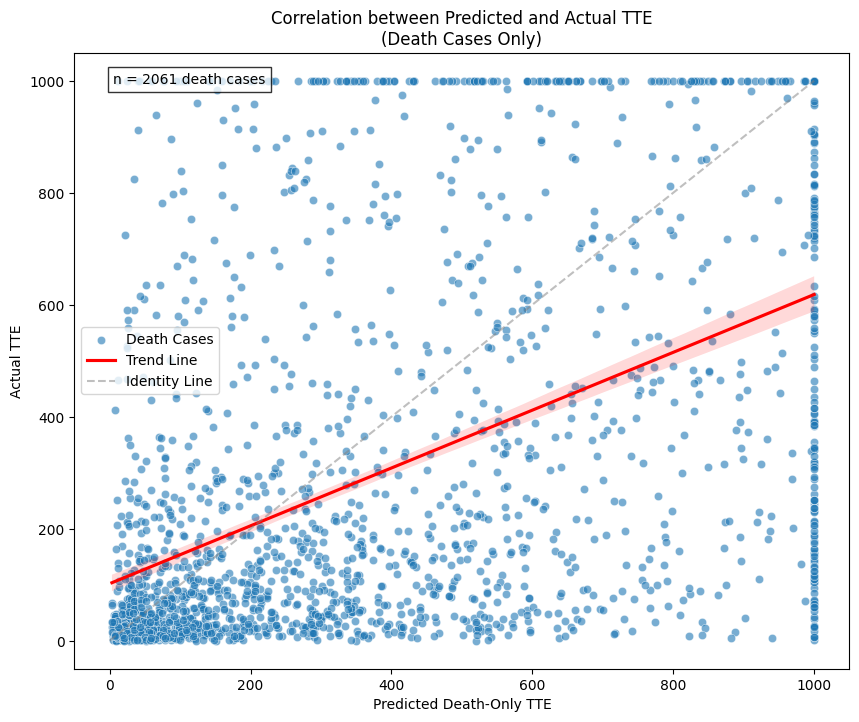


Summary statistics for death cases:

Predicted TTE:
count    2061.000000
mean      364.381876
std       329.032235
min         3.244227
25%        73.000000
50%       266.680012
75%       591.838306
max      1000.000000
Name: predicted_death_tte, dtype: float64

Actual TTE:
count    2061.000000
mean      290.055798
std       336.669362
min         0.000000
25%        29.000000
50%       130.000000
75%       462.000000
max      1000.000000
Name: tte, dtype: float64


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

# Filter for death outcomes only
death_mask = real_df['outcome'] == 0
death_df = real_df[death_mask]

# Compute correlation coefficients for death cases only
pearson_corr, pearson_p = pearsonr(death_df['predicted_death_tte'], death_df['tte'])
spearman_corr, spearman_p = spearmanr(death_df['predicted_death_tte'], death_df['tte'])

print("Correlation statistics for death outcomes only:")
print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3g})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3g})")

# Create a scatter plot with a regression line
plt.figure(figsize=(10,8))
sns.scatterplot(
    data=death_df,
    x='predicted_death_tte',
    y='tte',
    alpha=0.6,
    label='Death Cases'
)
sns.regplot(
    data=death_df,
    x='predicted_death_tte',
    y='tte',
    scatter=False,
    color='red',
    label='Trend Line'
)

plt.xlabel('Predicted Death-Only TTE')
plt.ylabel('Actual TTE')
plt.title('Correlation between Predicted and Actual TTE\n(Death Cases Only)')
plt.legend()

# Add number of death cases to the plot
n_deaths = len(death_df)
plt.text(
    0.05, 0.95,
    f'n = {n_deaths} death cases',
    transform=plt.gca().transAxes,
    bbox=dict(facecolor='white', alpha=0.8)
)

# Optional: Add identity line (y=x) for reference
min_val = min(death_df['predicted_death_tte'].min(), death_df['tte'].min())
max_val = max(death_df['predicted_death_tte'].max(), death_df['tte'].max())
plt.plot([min_val, max_val], [min_val, max_val], '--', color='gray', alpha=0.5, label='Identity Line')

plt.legend()
plt.show()

# Print additional statistics
print("\nSummary statistics for death cases:")
print("\nPredicted TTE:")
print(death_df['predicted_death_tte'].describe())
print("\nActual TTE:")
print(death_df['tte'].describe())

In [ ]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# Configuration
TOP_K = 10       # Updated: Number of closest neighbors who died
ALPHA = 1e-6      # Small constant to avoid division by zero in weights

def compute_weighted_death_tte(idx):
    """
    Compute a weighted average TTE based on the top TOP_K neighbors who died.
    Weights are set as 1/(distance + ALPHA). If fewer than TOP_K neighbors died,
    we use however many died. If none died, we fallback to the median TTE of all neighbors.
    """
    # Retrieve neighbor indices and distances for this real patient
    neighbor_idxs = indices_all[idx]
    neighbor_dists = distances_all[idx]

    # Build a DataFrame of neighbor data
    neighbors = syn_df_processed.loc[neighbor_idxs].copy()
    neighbors['dist'] = neighbor_dists

    # Filter neighbors to those who died (outcome=0), then sort by distance ascending
    death_neighbors = neighbors[neighbors['outcome'] == 0].sort_values('dist')

    # Take the top TOP_K
    selected = death_neighbors.head(TOP_K)

    if len(selected) > 0:
        # Compute inverse-distance weights
        w = 1.0 / (selected['dist'] + ALPHA)
        tte = selected['tte']
        weighted_tte = (w * tte).sum() / w.sum()
        return weighted_tte
    else:
        # Fallback: if no neighbor died, use the median TTE of all neighbors.
        return np.median(neighbors['tte'].values)

# Number of real patients (assumed to be available from your precomputed indices_all)
n_real = indices_all.shape[0]

# Compute the weighted TTE for each real patient in parallel with a progress bar
with tqdm_joblib(tqdm(desc="Computing weighted death-only TTE", total=n_real)) as progress_bar:
    predicted_tte = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_weighted_death_tte)(i) for i in range(n_real)
    )

predicted_tte = np.array(predicted_tte)

# Store the predictions in your real_df
real_df['predicted_death_only_tte'] = predicted_tte

# Optional: Display a sample of the predictions.
print(real_df[['predicted_death_only_tte']].head())





Computing weighted death-only TTE:   0%|          | 0/9395 [00:00<?, ?it/s]

  0%|          | 0/9395 [00:00<?, ?it/s]

   predicted_death_only_tte
0               1000.000000
1                187.869920
2                  8.000000
3                 46.556056
4                 30.208231


Among patients who died:
Pearson correlation between predicted TTE and actual tte: 0.4711742294119538
Spearman correlation between predicted TTE and actual tte: 0.5622756710969584


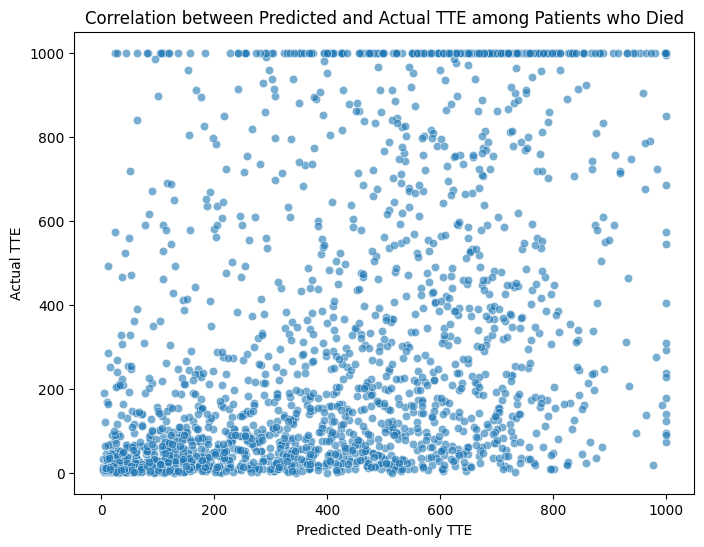

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter to patients who died (assuming outcome==0 indicates death)
df_died = real_df[real_df['outcome'] == 0].copy()

# Calculate Pearson and Spearman correlations among patients who died
pearson_corr_died = df_died['predicted_death_only_tte'].corr(df_died['tte'], method='pearson')
spearman_corr_died = df_died['predicted_death_only_tte'].corr(df_died['tte'], method='spearman')

print("Among patients who died:")
print("Pearson correlation between predicted TTE and actual tte:", pearson_corr_died)
print("Spearman correlation between predicted TTE and actual tte:", spearman_corr_died)

# Create a scatter plot for patients who died
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_died['predicted_death_only_tte'], y=df_died['tte'], alpha=0.6)
plt.xlabel("Predicted Death-only TTE")
plt.ylabel("Actual TTE")
plt.title("Correlation between Predicted and Actual TTE among Patients who Died")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter

def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data
        max_time: Optional maximum follow-up time to consider

    Returns:
        DataFrame prepared for survival analysis
    """
    # Create a copy of the input data
    analysis_df = df.copy()

    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)

    # If max_time is specified, adjust the data
    if max_time is not None:
        # For those who survived past max_time, censor at max_time
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0

    return analysis_df

def run_survival_analysis(df, time_points, max_iter=50):
    """
    Run survival analysis with enhanced performance and error handling.

    Args:
        df: DataFrame containing the data
        time_points: List of time points to analyze
        max_iter: Maximum iterations for model fitting

    Returns:
        DataFrame containing analysis results
    """
    required_cols = ['tte', 'outcome', 'predicted_death_only_tte', 'meld3']

    # Validate input data
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")

    hazard_results = []

    for t in time_points:
        print(f"Processing time point: {t}")  # Progress tracking

        try:
            # Prepare survival data
            analysis_df = prepare_survival_data(df, max_time=t)

            # --- Model 1: Using median_time_to_event_metric only ---
            cph_metric = CoxPHFitter()
            data_metric = analysis_df[['tte', 'death_event', 'predicted_death_only_tte']].copy()
            cph_metric.fit(data_metric,
                         duration_col='tte',
                         event_col='death_event',
                         show_progress=False,
                         max_iter=max_iter)
            c_index_metric = cph_metric.concordance_index_

            # --- Model 2: Using meld3 only ---
            cph_meld3 = CoxPHFitter()
            data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
            cph_meld3.fit(data_meld3,
                         duration_col='tte',
                         event_col='death_event',
                         show_progress=False,
                         max_iter=max_iter)
            c_index_meld3 = cph_meld3.concordance_index_

            # --- Model 3: Combined model using both predictors ---
            cph_combined = CoxPHFitter()
            data_combined = analysis_df[['tte', 'death_event',
                                       'predicted_death_only_tte', 'meld3']].copy()
            cph_combined.fit(data_combined,
                           duration_col='tte',
                           event_col='death_event',
                           show_progress=False,
                           max_iter=max_iter)
            c_index_combined = cph_combined.concordance_index_

            # Extract coefficients and p-values from summary
            summary = cph_combined.summary

            hazard_results.append({
                'Time': t,
                'c_index_metric': c_index_metric,
                'c_index_meld3': c_index_meld3,
                'c_index_combined': c_index_combined,
                'hr_metric': np.exp(summary.loc['predicted_death_only_tte', 'coef']),
                'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
                'p_metric': summary.loc['predicted_death_only_tte', 'p'],
                'p_meld3': summary.loc['meld3', 'p']
            })

        except Exception as e:
            print(f"Error at time point {t}: {str(e)}")
            continue

    if not hazard_results:
        raise ValueError("No results were generated. Check your input data and parameters.")

    return pd.DataFrame(hazard_results)

def print_results(results_df):
    """
    Print formatted analysis results.

    Args:
        results_df: DataFrame containing analysis results
    """
    print("\nComparison of Concordance Indices:")
    print(results_df[['Time', 'c_index_metric', 'c_index_meld3',
                     'c_index_combined']].round(3))
    print("\nHazard Ratios and P-values from Combined Model:")
    print(results_df[['Time', 'hr_metric', 'hr_meld3',
                     'p_metric', 'p_meld3']].round(3))

# Example usage:
# Define time points (e.g., every 30 days up to 360 days)
# time_points = np.arange(30, 361, 30)

# Run analysis with error handling
def main(df, time_points):
    """
    Main function to run the analysis with error handling.

    Args:
        df: Input DataFrame
        time_points: List of time points to analyze
    """
    try:
        results_df = run_survival_analysis(df, time_points, max_iter=50)
        print_results(results_df)
        return results_df
    except Exception as e:
        print(f"Analysis failed: {str(e)}")
        return None

In [ ]:
# Define time points
time_points = [7, 14, 30, 90, 180, 360]

def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data
        max_time: Optional maximum follow-up time to consider

    Returns:
        DataFrame prepared for survival analysis
    """
    # Create a copy of the input data
    analysis_df = df.copy()

    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)

    # If max_time is specified, adjust the data
    if max_time is not None:
        # For those who survived past max_time, censor at max_time
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0

    return analysis_df

# Now run the concordance analysis
hazard_results = []

for t in time_points:
    # Prepare survival data
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_death_only_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_death_only_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event',
                                'predicted_death_only_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte',
                    event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from summary
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_death_only_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_death_only_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print results in a formatted way
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))


Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.708          0.894             0.895
1    14           0.695          0.874             0.874
2    30           0.676          0.859             0.859
3    90           0.654          0.824             0.826
4   180           0.644          0.803             0.804
5   360           0.639          0.784             0.786

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      0.999     1.148     0.002      0.0
1    14      0.999     1.145     0.000      0.0
2    30      0.999     1.139     0.000      0.0
3    90      0.999     1.123     0.000      0.0
4   180      0.999     1.113     0.000      0.0
5   360      0.999     1.103     0.000      0.0


Weighted

In [ ]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# Configuration
TOP_K = 100       # Use the 100 closest neighbors
ALPHA = 1e-6      # Small constant to avoid division by zero

def compute_weighted_composite_tte(idx):
    """
    Compute a composite weighted average tte based on the TOP_K nearest neighbors.
    For each outcome group (0: death, 1: waiting, 2: transplant):
      - Compute a weighted average tte using inverse-distance weighting.
      - Compute the proportion of neighbors in that group.
    The final predicted tte is the sum of each group's (weighted average tte × proportion).

    If a given group is absent, its contribution is 0.
    """
    # Retrieve neighbor indices and distances for this real patient.
    neighbor_idxs = indices_all[idx]
    neighbor_dists = distances_all[idx]

    # Build a DataFrame for these neighbors.
    neighbors = syn_df_processed.loc[neighbor_idxs].copy()
    neighbors['dist'] = neighbor_dists

    total_neighbors = len(neighbors)
    composite_tte = 0.0

    # Loop over each outcome group: 0, 1, 2.
    for outcome in [0, 1, 2]:
        # Get subset for this outcome (if any)
        subset = neighbors[neighbors['outcome'] == outcome]
        if len(subset) > 0:
            # Use only the TOP_K closest neighbors within this outcome group.
            subset = subset.sort_values('dist').head(TOP_K)
            # Compute inverse-distance weights.
            weights = 1.0 / (subset['dist'] + ALPHA)
            weighted_avg = (weights * subset['tte']).sum() / weights.sum()
            proportion = len(subset) / total_neighbors
            composite_tte += weighted_avg * proportion
        else:
            # No neighbors in this group contribute.
            composite_tte += 0.0
    return composite_tte

# Number of real patients (assumed available from indices_all)
n_real = indices_all.shape[0]

# Compute the composite predicted TTE for each real patient in parallel.
with tqdm_joblib(tqdm(desc="Computing composite weighted TTE", total=n_real)) as progress_bar:
    predicted_tte = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_weighted_composite_tte)(i) for i in range(n_real)
    )
predicted_tte = np.array(predicted_tte)

# Store the predictions in your real_df under a new column.
real_df['predicted_composite_tte'] = predicted_tte

# Optional: display a sample of the predictions.
print(real_df[['predicted_composite_tte']].head())


Computing composite weighted TTE:   0%|          | 0/9395 [00:00<?, ?it/s]

  0%|          | 0/9395 [00:00<?, ?it/s]

   predicted_composite_tte
0               883.523324
1               550.669953
2               686.759871
3               120.748410
4                55.891400


In [ ]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from tqdm.notebook import tqdm

def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()
    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)
    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0
    return analysis_df

# Assume time_points is defined, e.g.:
time_points = [7, 14, 30, 90, 180, 360]

hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_composite_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_composite_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary.
    # Here we assume that the row label for our composite TTE predictor is 'predicted_composite_tte'
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_composite_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_composite_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.881          0.894             0.908
1    14           0.869          0.874             0.893
2    30           0.859          0.859             0.881
3    90           0.842          0.824             0.858
4   180           0.832          0.803             0.843
5   360           0.828          0.784             0.833

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      0.997     1.113       0.0      0.0
1    14      0.997     1.110       0.0      0.0
2    30      0.997     1.103       0.0      0.0
3    90      0.997     1.088       0.0      0.0
4   180      0.997     1.077       0.0      0.0
5   360      0.997     1.065       0.0      0.0


In [ ]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# Configuration
TOP_K = 30       # Use the 100 closest neighbors
ALPHA = 1e-6      # Small constant to avoid division by zero

def compute_weighted_composite_tte(idx):
    """
    Compute a composite weighted average tte based on the TOP_K nearest neighbors.
    For each outcome group (0: death, 1: waiting, 2: transplant):
      - Compute a weighted average tte using inverse-distance weighting.
      - Compute the proportion of neighbors in that group.
    The final predicted tte is the sum of each group's (weighted average tte × proportion).

    If a given group is absent, its contribution is 0.
    """
    # Retrieve neighbor indices and distances for this real patient.
    neighbor_idxs = indices_all[idx]
    neighbor_dists = distances_all[idx]

    # Build a DataFrame for these neighbors.
    neighbors = syn_df_processed.loc[neighbor_idxs].copy()
    neighbors['dist'] = neighbor_dists

    total_neighbors = len(neighbors)
    composite_tte = 0.0

    # Loop over each outcome group: 0, 1, 2.
    for outcome in [0, 1, 2]:
        # Get subset for this outcome (if any)
        subset = neighbors[neighbors['outcome'] == outcome]
        if len(subset) > 0:
            # Use only the TOP_K closest neighbors within this outcome group.
            subset = subset.sort_values('dist').head(TOP_K)
            # Compute inverse-distance weights.
            weights = 1.0 / (subset['dist'] + ALPHA)
            weighted_avg = (weights * subset['tte']).sum() / weights.sum()
            proportion = len(subset) / total_neighbors
            composite_tte += weighted_avg * proportion
        else:
            # No neighbors in this group contribute.
            composite_tte += 0.0
    return composite_tte

# Number of real patients (assumed available from indices_all)
n_real = indices_all.shape[0]

# Compute the composite predicted TTE for each real patient in parallel.
with tqdm_joblib(tqdm(desc="Computing composite weighted TTE", total=n_real)) as progress_bar:
    predicted_tte = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_weighted_composite_tte)(i) for i in range(n_real)
    )
predicted_tte = np.array(predicted_tte)

# Store the predictions in your real_df under a new column.
real_df['predicted_composite_tte'] = predicted_tte

# Optional: display a sample of the predictions.
print(real_df[['predicted_composite_tte']].head())


Computing composite weighted TTE:   0%|          | 0/9395 [00:00<?, ?it/s]

  0%|          | 0/9395 [00:00<?, ?it/s]

   predicted_composite_tte
0               253.816832
1               264.468979
2               271.384518
3                29.864591
4                15.920428


In [ ]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from tqdm.notebook import tqdm

def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()
    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)
    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0
    return analysis_df

# Assume time_points is defined, e.g.:
time_points = [7, 14, 30, 90, 180, 360]

hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_composite_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_composite_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary.
    # Here we assume that the row label for our composite TTE predictor is 'predicted_composite_tte'
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_composite_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_composite_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.877          0.894             0.911
1    14           0.869          0.874             0.896
2    30           0.861          0.859             0.886
3    90           0.855          0.824             0.869
4   180           0.851          0.803             0.860
5   360           0.853          0.784             0.856

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      0.991     1.116       0.0      0.0
1    14      0.991     1.113       0.0      0.0
2    30      0.992     1.106       0.0      0.0
3    90      0.991     1.089       0.0      0.0
4   180      0.991     1.077       0.0      0.0
5   360      0.990     1.063       0.0      0.0


In [ ]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# Configuration
TOP_K = 20       # Use the 100 closest neighbors
ALPHA = 1e-6      # Small constant to avoid division by zero

def compute_weighted_composite_tte(idx):
    """
    Compute a composite weighted average tte based on the TOP_K nearest neighbors.
    For each outcome group (0: death, 1: waiting, 2: transplant):
      - Compute a weighted average tte using inverse-distance weighting.
      - Compute the proportion of neighbors in that group.
    The final predicted tte is the sum of each group's (weighted average tte × proportion).

    If a given group is absent, its contribution is 0.
    """
    # Retrieve neighbor indices and distances for this real patient.
    neighbor_idxs = indices_all[idx]
    neighbor_dists = distances_all[idx]

    # Build a DataFrame for these neighbors.
    neighbors = syn_df_processed.loc[neighbor_idxs].copy()
    neighbors['dist'] = neighbor_dists

    total_neighbors = len(neighbors)
    composite_tte = 0.0

    # Loop over each outcome group: 0, 1, 2.
    for outcome in [0, 1, 2]:
        # Get subset for this outcome (if any)
        subset = neighbors[neighbors['outcome'] == outcome]
        if len(subset) > 0:
            # Use only the TOP_K closest neighbors within this outcome group.
            subset = subset.sort_values('dist').head(TOP_K)
            # Compute inverse-distance weights.
            weights = 1.0 / (subset['dist'] + ALPHA)
            weighted_avg = (weights * subset['tte']).sum() / weights.sum()
            proportion = len(subset) / total_neighbors
            composite_tte += weighted_avg * proportion
        else:
            # No neighbors in this group contribute.
            composite_tte += 0.0
    return composite_tte

# Number of real patients (assumed available from indices_all)
n_real = indices_all.shape[0]

# Compute the composite predicted TTE for each real patient in parallel.
with tqdm_joblib(tqdm(desc="Computing composite weighted TTE", total=n_real)) as progress_bar:
    predicted_tte = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_weighted_composite_tte)(i) for i in range(n_real)
    )
predicted_tte = np.array(predicted_tte)

# Store the predictions in your real_df under a new column.
real_df['predicted_composite_tte'] = predicted_tte

# Optional: display a sample of the predictions.
print(real_df[['predicted_composite_tte']].head())


Computing composite weighted TTE:   0%|          | 0/9395 [00:00<?, ?it/s]

  0%|          | 0/9395 [00:00<?, ?it/s]

   predicted_composite_tte
0               157.791256
1               196.335301
2               190.917674
3                13.758004
4                 5.253261


In [ ]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from tqdm.notebook import tqdm

def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()
    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)
    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0
    return analysis_df

# Assume time_points is defined, e.g.:
time_points = [7, 14, 30, 90, 180, 360]

hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_composite_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_composite_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary.
    # Here we assume that the row label for our composite TTE predictor is 'predicted_composite_tte'
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_composite_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_composite_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.880          0.894             0.913
1    14           0.871          0.874             0.897
2    30           0.862          0.859             0.887
3    90           0.856          0.824             0.871
4   180           0.852          0.803             0.861
5   360           0.853          0.784             0.857

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      0.985     1.114       0.0      0.0
1    14      0.987     1.112       0.0      0.0
2    30      0.987     1.106       0.0      0.0
3    90      0.987     1.089       0.0      0.0
4   180      0.986     1.077       0.0      0.0
5   360      0.985     1.064       0.0      0.0


In [ ]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# Configuration
TOP_K = 10       # Use the 100 closest neighbors
ALPHA = 1e-6      # Small constant to avoid division by zero

def compute_weighted_composite_tte(idx):
    """
    Compute a composite weighted average tte based on the TOP_K nearest neighbors.
    For each outcome group (0: death, 1: waiting, 2: transplant):
      - Compute a weighted average tte using inverse-distance weighting.
      - Compute the proportion of neighbors in that group.
    The final predicted tte is the sum of each group's (weighted average tte × proportion).

    If a given group is absent, its contribution is 0.
    """
    # Retrieve neighbor indices and distances for this real patient.
    neighbor_idxs = indices_all[idx]
    neighbor_dists = distances_all[idx]

    # Build a DataFrame for these neighbors.
    neighbors = syn_df_processed.loc[neighbor_idxs].copy()
    neighbors['dist'] = neighbor_dists

    total_neighbors = len(neighbors)
    composite_tte = 0.0

    # Loop over each outcome group: 0, 1, 2.
    for outcome in [0, 1, 2]:
        # Get subset for this outcome (if any)
        subset = neighbors[neighbors['outcome'] == outcome]
        if len(subset) > 0:
            # Use only the TOP_K closest neighbors within this outcome group.
            subset = subset.sort_values('dist').head(TOP_K)
            # Compute inverse-distance weights.
            weights = 1.0 / (subset['dist'] + ALPHA)
            weighted_avg = (weights * subset['tte']).sum() / weights.sum()
            proportion = len(subset) / total_neighbors
            composite_tte += weighted_avg * proportion
        else:
            # No neighbors in this group contribute.
            composite_tte += 0.0
    return composite_tte

# Number of real patients (assumed available from indices_all)
n_real = indices_all.shape[0]

# Compute the composite predicted TTE for each real patient in parallel.
with tqdm_joblib(tqdm(desc="Computing composite weighted TTE", total=n_real)) as progress_bar:
    predicted_tte = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_weighted_composite_tte)(i) for i in range(n_real)
    )
predicted_tte = np.array(predicted_tte)

# Store the predictions in your real_df under a new column.
real_df['predicted_composite_tte'] = predicted_tte

# Optional: display a sample of the predictions.
print(real_df[['predicted_composite_tte']].head())




Computing composite weighted TTE:   0%|          | 0/9395 [00:00<?, ?it/s]

  0%|          | 0/9395 [00:00<?, ?it/s]

   predicted_composite_tte
0                71.396196
1               110.066001
2                97.558020
3                 5.211409
4                 3.020823


In [ ]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from tqdm.notebook import tqdm

def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()
    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)
    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0
    return analysis_df

# Assume time_points is defined, e.g.:
time_points = [7, 14, 30, 90, 180, 360]

hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_composite_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_composite_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary.
    # Here we assume that the row label for our composite TTE predictor is 'predicted_composite_tte'
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_composite_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_composite_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.875          0.894             0.912
1    14           0.866          0.874             0.896
2    30           0.855          0.859             0.883
3    90           0.851          0.824             0.869
4   180           0.847          0.803             0.859
5   360           0.848          0.784             0.855

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      0.972     1.117       0.0      0.0
1    14      0.975     1.114       0.0      0.0
2    30      0.976     1.109       0.0      0.0
3    90      0.974     1.091       0.0      0.0
4   180      0.974     1.079       0.0      0.0
5   360      0.972     1.066       0.0      0.0


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

def prepare_data_for_time_auc(df, time_point):
    """
    Prepare data for time-dependent AUC calculation.

    Args:
        df: DataFrame with tte, outcome, and predictors
        time_point: Time point for analysis

    Returns:
        DataFrame with binary outcome for the specific time point
    """
    # Create binary outcome (death/transplant = 1, waiting = 0)
    mask_event = (df['outcome'].isin([0, 2]))  # death or transplant

    # For the specific time point:
    # - Event = 1 if event happened before time_point
    # - Event = 0 if subject survived past time_point
    # - Exclude if censored before time_point
    time_mask = df['tte'] <= time_point
    binary_outcome = ((mask_event) & (time_mask)).astype(int)

    # Create analysis dataset
    analysis_df = df.copy()
    analysis_df['binary_outcome'] = binary_outcome

    # Only include patients who either:
    # 1) Had an event by time_point
    # 2) Were followed for at least time_point days
    include_mask = (mask_event & time_mask) | (df['tte'] >= time_point)

    return analysis_df[include_mask]

# Define time points
time_points = [7, 14, 30, 90, 180, 360]

# Store results
auc_results = []

# Calculate AUC for each time point
for t in time_points:
    # Prepare data for this time point
    analysis_df = prepare_data_for_time_auc(real_df, t)

    # Calculate AUCs if we have both events and non-events
    if (analysis_df['binary_outcome'].sum() > 0 and
        (len(analysis_df) - analysis_df['binary_outcome'].sum()) > 0):

        # Calculate individual AUCs
        auc_meld = roc_auc_score(analysis_df['binary_outcome'], analysis_df['meld3'])
        # Flip sign for predicted_composite_tte since lower values indicate higher risk
        auc_pred = roc_auc_score(analysis_df['binary_outcome'], -analysis_df['predicted_composite_tte'])

        # Calculate combined model AUC using logistic regression predictions
        from sklearn.linear_model import LogisticRegression
        # Use negative of predicted_composite_tte
        X_combined = pd.DataFrame({
            'meld3': analysis_df['meld3'],
            'predicted_tte': -analysis_df['predicted_composite_tte']
        })
        y = analysis_df['binary_outcome']

        # Fit logistic regression and get predictions
        lr = LogisticRegression(random_state=42)
        lr.fit(X_combined, y)
        combined_preds = lr.predict_proba(X_combined)[:, 1]
        auc_combined = roc_auc_score(y, combined_preds)

        # Store results
        auc_results.append({
            'Time': t,
            'N_samples': len(analysis_df),
            'N_events': analysis_df['binary_outcome'].sum(),
            'AUC_MELD3': auc_meld,
            'AUC_predicted': auc_pred,
            'AUC_combined': auc_combined
        })

# Convert to DataFrame and display results
results_df = pd.DataFrame(auc_results)
print("\nTime-dependent AUC Results:")
print(results_df.round(3))


Time-dependent AUC Results:
   Time  N_samples  N_events  AUC_MELD3  AUC_predicted  AUC_combined
0     7       9389       572      0.798          0.896         0.897
1    14       9362       907      0.836          0.914         0.916
2    30       9299      1375      0.845          0.923         0.926
3    90       9071      2148      0.829          0.932         0.934
4   180       8734      2725      0.814          0.940         0.941
5   360       8145      3263      0.800          0.955         0.954


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

def prepare_data_for_time_auc(df, time_point):
    """
    Prepare data for time-dependent AUC calculation for mortality prediction.

    Args:
        df: DataFrame with tte, outcome, and predictors
        time_point: Time point for analysis

    Returns:
        DataFrame with binary outcome for the specific time point
    """
    # Create binary outcome (death = 1, alive = 0)
    mask_death = (df['outcome'] == 0)  # death only

    # For the specific time point:
    # - Event = 1 if death happened before time_point
    # - Event = 0 if subject survived past time_point
    # - Exclude if transplanted or censored before time_point
    time_mask = df['tte'] <= time_point
    binary_outcome = ((mask_death) & (time_mask)).astype(int)

    # Create analysis dataset
    analysis_df = df.copy()
    analysis_df['binary_outcome'] = binary_outcome

    # Only include patients who either:
    # 1) Died by time_point
    # 2) Were followed for at least time_point days
    # 3) Exclude those who got transplant before time_point
    transplant_mask = (df['outcome'] == 2) & (df['tte'] <= time_point)
    include_mask = ((mask_death & time_mask) | (df['tte'] >= time_point)) & ~transplant_mask

    return analysis_df[include_mask]

# Define time points
time_points = [7, 14, 30, 90, 180, 360]

# Store results
auc_results = []

# Calculate AUC for each time point
for t in time_points:
    # Prepare data for this time point
    analysis_df = prepare_data_for_time_auc(real_df, t)

    # Calculate AUCs if we have both events and non-events
    if (analysis_df['binary_outcome'].sum() > 0 and
        (len(analysis_df) - analysis_df['binary_outcome'].sum()) > 0):

        # Calculate individual AUCs
        auc_meld = roc_auc_score(analysis_df['binary_outcome'], analysis_df['meld3'])
        # Flip sign for predicted_composite_tte since lower values indicate higher risk
        auc_pred = roc_auc_score(analysis_df['binary_outcome'], -analysis_df['predicted_composite_tte'])

        # Calculate combined model AUC using logistic regression predictions
        from sklearn.linear_model import LogisticRegression
        # Use negative of predicted_composite_tte
        X_combined = pd.DataFrame({
            'meld3': analysis_df['meld3'],
            'predicted_tte': -analysis_df['predicted_composite_tte']
        })
        y = analysis_df['binary_outcome']

        # Fit logistic regression and get predictions
        lr = LogisticRegression(random_state=42)
        lr.fit(X_combined, y)
        combined_preds = lr.predict_proba(X_combined)[:, 1]
        auc_combined = roc_auc_score(y, combined_preds)

        # Store results
        auc_results.append({
            'Time': t,
            'N_samples': len(analysis_df),
            'N_events': analysis_df['binary_outcome'].sum(),
            'AUC_MELD3': auc_meld,
            'AUC_predicted': auc_pred,
            'AUC_combined': auc_combined
        })

# Convert to DataFrame and display results
results_df = pd.DataFrame(auc_results)
print("\nTime-dependent AUC Results (Mortality):")
print(results_df.round(3))


Time-dependent AUC Results (Mortality):
   Time  N_samples  N_events  AUC_MELD3  AUC_predicted  AUC_combined
0     7       8973       156      0.902          0.892         0.922
1    14       8770       315      0.887          0.891         0.912
2    30       8455       531      0.877          0.891         0.909
3    90       7824       901      0.845          0.900         0.906
4   180       7179      1170      0.824          0.909         0.911
5   360       6328      1446      0.803          0.927         0.927


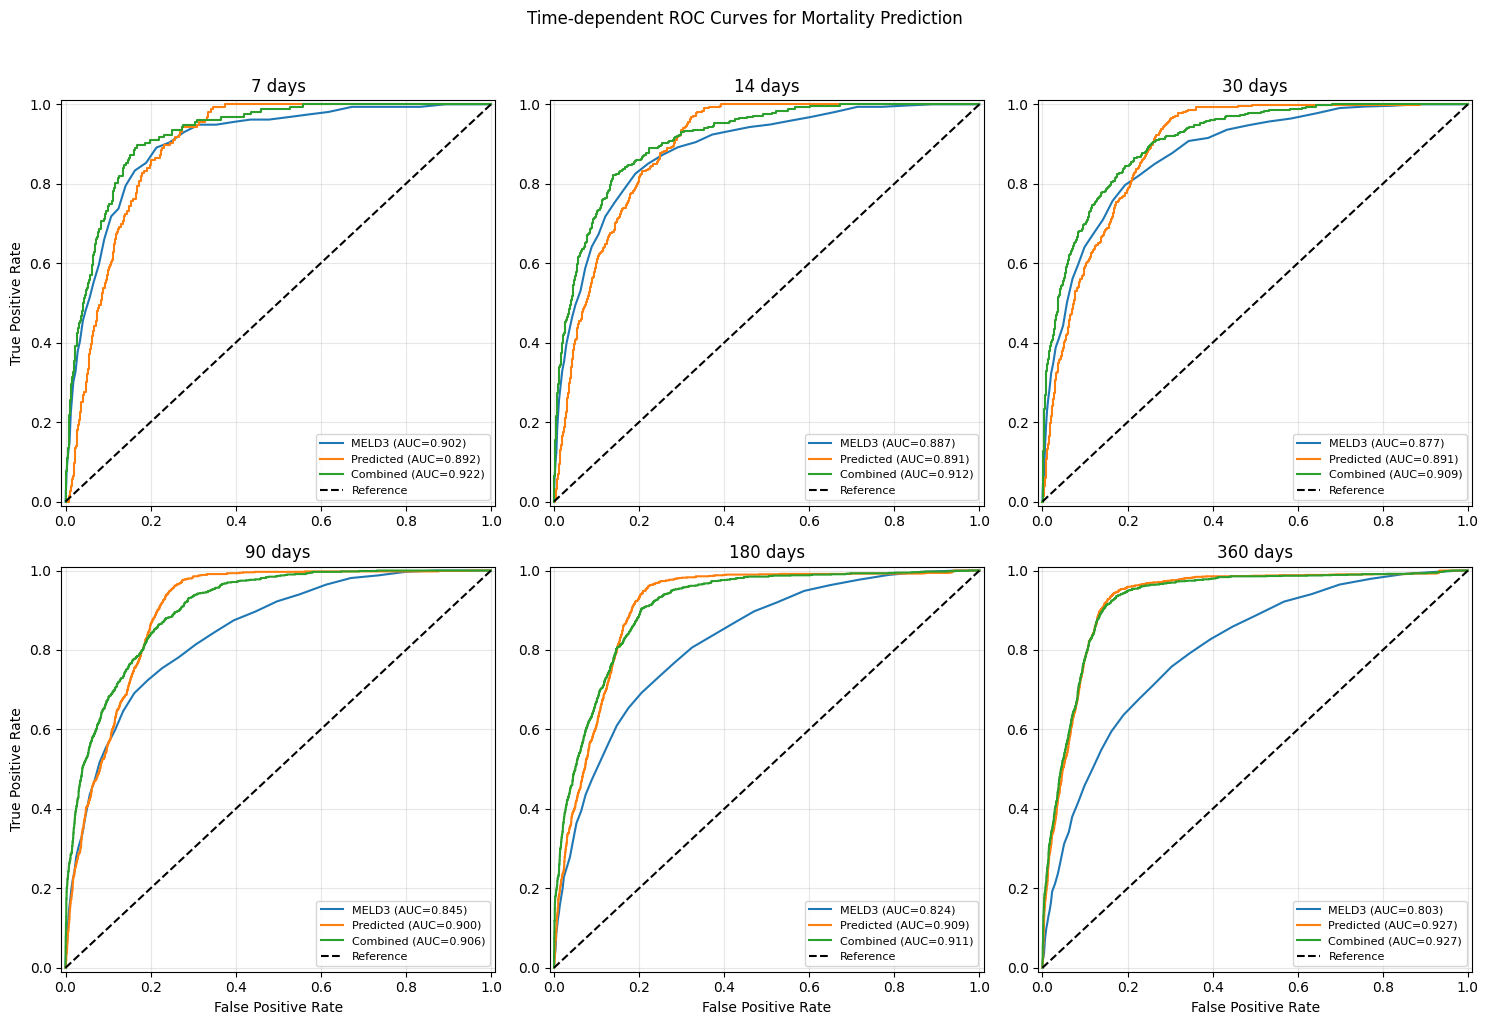


Time-dependent AUC Results (Mortality):
   Time  N_samples  N_events  AUC_MELD3  AUC_predicted  AUC_combined
0     7       8973       156      0.902          0.892         0.922
1    14       8770       315      0.887          0.891         0.912
2    30       8455       531      0.877          0.891         0.909
3    90       7824       901      0.845          0.900         0.906
4   180       7179      1170      0.824          0.909         0.911
5   360       6328      1446      0.803          0.927         0.927


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

def prepare_data_for_time_auc(df, time_point):
    """
    Prepare data for time-dependent AUC calculation for mortality prediction.
    """
    mask_death = (df['outcome'] == 0)  # death only
    time_mask = df['tte'] <= time_point
    binary_outcome = ((mask_death) & (time_mask)).astype(int)

    analysis_df = df.copy()
    analysis_df['binary_outcome'] = binary_outcome

    transplant_mask = (df['outcome'] == 2) & (df['tte'] <= time_point)
    include_mask = ((mask_death & time_mask) | (df['tte'] >= time_point)) & ~transplant_mask

    return analysis_df[include_mask]

# Define time points and colors
time_points = [7, 14, 30, 90, 180, 360]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # blue, orange, green

# Create figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Store results
auc_results = []

# Calculate AUC and ROC curves for each time point
for i, t in enumerate(time_points):
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    # Prepare data for this time point
    analysis_df = prepare_data_for_time_auc(real_df, t)

    if (analysis_df['binary_outcome'].sum() > 0 and
        (len(analysis_df) - analysis_df['binary_outcome'].sum()) > 0):

        y = analysis_df['binary_outcome']

        # MELD3
        fpr_meld, tpr_meld, _ = roc_curve(y, analysis_df['meld3'])
        auc_meld = roc_auc_score(y, analysis_df['meld3'])

        # Predicted TTE
        fpr_pred, tpr_pred, _ = roc_curve(y, -analysis_df['predicted_composite_tte'])
        auc_pred = roc_auc_score(y, -analysis_df['predicted_composite_tte'])

        # Combined
        X_combined = pd.DataFrame({
            'meld3': analysis_df['meld3'],
            'predicted_tte': -analysis_df['predicted_composite_tte']
        })

        lr = LogisticRegression(random_state=42)
        lr.fit(X_combined, y)
        combined_preds = lr.predict_proba(X_combined)[:, 1]
        fpr_comb, tpr_comb, _ = roc_curve(y, combined_preds)
        auc_combined = roc_auc_score(y, combined_preds)

        # Plot ROC curves
        ax.plot(fpr_meld, tpr_meld, color=colors[0],
                label=f'MELD3 (AUC={auc_meld:.3f})')
        ax.plot(fpr_pred, tpr_pred, color=colors[1],
                label=f'Predicted (AUC={auc_pred:.3f})')
        ax.plot(fpr_comb, tpr_comb, color=colors[2],
                label=f'Combined (AUC={auc_combined:.3f})')

        # Add diagonal reference line
        ax.plot([0, 1], [0, 1], 'k--', label='Reference')

        # Store results
        auc_results.append({
            'Time': t,
            'N_samples': len(analysis_df),
            'N_events': analysis_df['binary_outcome'].sum(),
            'AUC_MELD3': auc_meld,
            'AUC_predicted': auc_pred,
            'AUC_combined': auc_combined
        })

    # Customize subplot
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    ax.set_title(f'{t} days')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower right', fontsize=8)

    # Only add axis labels for edge subplots
    if row == 1:
        ax.set_xlabel('False Positive Rate')
    if col == 0:
        ax.set_ylabel('True Positive Rate')

# Add overall title
fig.suptitle('Time-dependent ROC Curves for Mortality Prediction', y=1.02)

# Adjust layout and save
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Print AUC results table
results_df = pd.DataFrame(auc_results)
print("\nTime-dependent AUC Results (Mortality):")
print(results_df.round(3))

Weighted Composite Outcome

In [ ]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# Configuration
TOP_K = 10       # Use the 30 closest neighbors
ALPHA = 1e-6     # Small constant to avoid division by zero

def compute_weighted_composite_tte(idx):
    """
    Compute a composite weighted average tte based on the TOP_K nearest neighbors.
    Groups are:
      - Group 0: death or transplant (outcomes 0 or 2)
      - Group 1: waiting (outcome 1)
    The final predicted tte is the sum of each group's (weighted average tte × proportion).
    If a given group is absent, its contribution is 0.
    """
    # Retrieve neighbor indices and distances for this real patient
    neighbor_idxs = indices_all[idx]
    neighbor_dists = distances_all[idx]

    # Build a DataFrame for these neighbors
    neighbors = syn_df_processed.loc[neighbor_idxs].copy()
    neighbors['dist'] = neighbor_dists

    # Create binary grouping: death/transplant (0) vs waiting (1)
    neighbors['binary_outcome'] = (neighbors['outcome'] == 1).astype(int)

    total_neighbors = len(neighbors)
    composite_tte = 0.0

    # Loop over binary outcomes: 0 (death/transplant) and 1 (waiting)
    for outcome in [0, 1]:
        # Get subset for this outcome (if any)
        subset = neighbors[neighbors['binary_outcome'] == outcome]
        if len(subset) > 0:
            # Use only the TOP_K closest neighbors within this outcome group
            subset = subset.sort_values('dist').head(TOP_K)
            # Compute inverse-distance weights
            weights = 1.0 / (subset['dist'] + ALPHA)
            weighted_avg = (weights * subset['tte']).sum() / weights.sum()
            proportion = len(subset) / total_neighbors
            composite_tte += weighted_avg * proportion
        else:
            # No neighbors in this group contribute
            composite_tte += 0.0

    return composite_tte

# Number of real patients
n_real = indices_all.shape[0]

# Compute the composite predicted TTE for each real patient in parallel
with tqdm_joblib(tqdm(desc="Computing composite weighted TTE", total=n_real)) as progress_bar:
    predicted_tte = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_weighted_composite_tte)(i) for i in range(n_real)
    )
predicted_tte = np.array(predicted_tte)

# Store the predictions in real_df
real_df['predicted_death_only_tte'] = predicted_tte

# Optional: display a sample of the predictions
print(real_df[['predicted_death_only_tte']].head())


Computing composite weighted TTE:   0%|          | 0/9395 [00:00<?, ?it/s]

  0%|          | 0/9395 [00:00<?, ?it/s]

   predicted_death_only_tte
0                 71.396196
1                107.485078
2                 97.398020
3                  5.211409
4                  3.020823


In [ ]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from tqdm.notebook import tqdm

def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()
    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)
    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0
    return analysis_df

# Assume time_points is defined, e.g.:
time_points = [7, 14, 30, 90, 180, 360]

hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_composite_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_composite_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary.
    # Here we assume that the row label for our composite TTE predictor is 'predicted_composite_tte'
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_composite_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_composite_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.881          0.894             0.908
1    14           0.869          0.874             0.893
2    30           0.859          0.859             0.881
3    90           0.842          0.824             0.858
4   180           0.832          0.803             0.843
5   360           0.828          0.784             0.833

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      0.997     1.113       0.0      0.0
1    14      0.997     1.110       0.0      0.0
2    30      0.997     1.103       0.0      0.0
3    90      0.997     1.088       0.0      0.0
4   180      0.997     1.077       0.0      0.0
5   360      0.997     1.065       0.0      0.0


In [ ]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# Configuration
TOP_K = 20       # Use the 30 closest neighbors
ALPHA = 1e-6     # Small constant to avoid division by zero

def compute_weighted_composite_tte(idx):
    """
    Compute a composite weighted average tte based on the TOP_K nearest neighbors.
    Groups are:
      - Group 0: death or transplant (outcomes 0 or 2)
      - Group 1: waiting (outcome 1)
    The final predicted tte is the sum of each group's (weighted average tte × proportion).
    If a given group is absent, its contribution is 0.
    """
    # Retrieve neighbor indices and distances for this real patient
    neighbor_idxs = indices_all[idx]
    neighbor_dists = distances_all[idx]

    # Build a DataFrame for these neighbors
    neighbors = syn_df_processed.loc[neighbor_idxs].copy()
    neighbors['dist'] = neighbor_dists

    # Create binary grouping: death/transplant (0) vs waiting (1)
    neighbors['binary_outcome'] = (neighbors['outcome'] == 1).astype(int)

    total_neighbors = len(neighbors)
    composite_tte = 0.0

    # Loop over binary outcomes: 0 (death/transplant) and 1 (waiting)
    for outcome in [0, 1]:
        # Get subset for this outcome (if any)
        subset = neighbors[neighbors['binary_outcome'] == outcome]
        if len(subset) > 0:
            # Use only the TOP_K closest neighbors within this outcome group
            subset = subset.sort_values('dist').head(TOP_K)
            # Compute inverse-distance weights
            weights = 1.0 / (subset['dist'] + ALPHA)
            weighted_avg = (weights * subset['tte']).sum() / weights.sum()
            proportion = len(subset) / total_neighbors
            composite_tte += weighted_avg * proportion
        else:
            # No neighbors in this group contribute
            composite_tte += 0.0

    return composite_tte

# Number of real patients
n_real = indices_all.shape[0]

# Compute the composite predicted TTE for each real patient in parallel
with tqdm_joblib(tqdm(desc="Computing composite weighted TTE", total=n_real)) as progress_bar:
    predicted_tte = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_weighted_composite_tte)(i) for i in range(n_real)
    )
predicted_tte = np.array(predicted_tte)

# Store the predictions in real_df
real_df['predicted_death_only_tte'] = predicted_tte

# Optional: display a sample of the predictions
print(real_df[['predicted_death_only_tte']].head())



Computing composite weighted TTE:   0%|          | 0/9395 [00:00<?, ?it/s]

  0%|          | 0/9395 [00:00<?, ?it/s]

Computing composite weighted TTE:   0%|          | 0/9395 [01:26<?, ?it/s]


   predicted_death_only_tte
0                157.791256
1                194.033901
2                190.918711
3                 13.758004
4                  5.253261


In [ ]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from tqdm.notebook import tqdm

def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()
    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)
    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0
    return analysis_df

# Assume time_points is defined, e.g.:
time_points = [7, 14, 30, 90, 180, 360]

hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_composite_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_composite_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary.
    # Here we assume that the row label for our composite TTE predictor is 'predicted_composite_tte'
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_composite_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_composite_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.877          0.894             0.911
1    14           0.869          0.874             0.896
2    30           0.861          0.859             0.886
3    90           0.855          0.824             0.869
4   180           0.851          0.803             0.860
5   360           0.853          0.784             0.856

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      0.991     1.116       0.0      0.0
1    14      0.991     1.113       0.0      0.0
2    30      0.992     1.106       0.0      0.0
3    90      0.991     1.089       0.0      0.0
4   180      0.991     1.077       0.0      0.0
5   360      0.990     1.063       0.0      0.0


In [ ]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# Configuration
TOP_K = 50       # Use the 30 closest neighbors
ALPHA = 1e-6     # Small constant to avoid division by zero

def compute_weighted_composite_tte(idx):
    """
    Compute a composite weighted average tte based on the TOP_K nearest neighbors.
    Groups are:
      - Group 0: death or transplant (outcomes 0 or 2)
      - Group 1: waiting (outcome 1)
    The final predicted tte is the sum of each group's (weighted average tte × proportion).
    If a given group is absent, its contribution is 0.
    """
    # Retrieve neighbor indices and distances for this real patient
    neighbor_idxs = indices_all[idx]
    neighbor_dists = distances_all[idx]

    # Build a DataFrame for these neighbors
    neighbors = syn_df_processed.loc[neighbor_idxs].copy()
    neighbors['dist'] = neighbor_dists

    # Create binary grouping: death/transplant (0) vs waiting (1)
    neighbors['binary_outcome'] = (neighbors['outcome'] == 1).astype(int)

    total_neighbors = len(neighbors)
    composite_tte = 0.0

    # Loop over binary outcomes: 0 (death/transplant) and 1 (waiting)
    for outcome in [0, 1]:
        # Get subset for this outcome (if any)
        subset = neighbors[neighbors['binary_outcome'] == outcome]
        if len(subset) > 0:
            # Use only the TOP_K closest neighbors within this outcome group
            subset = subset.sort_values('dist').head(TOP_K)
            # Compute inverse-distance weights
            weights = 1.0 / (subset['dist'] + ALPHA)
            weighted_avg = (weights * subset['tte']).sum() / weights.sum()
            proportion = len(subset) / total_neighbors
            composite_tte += weighted_avg * proportion
        else:
            # No neighbors in this group contribute
            composite_tte += 0.0

    return composite_tte

# Number of real patients
n_real = indices_all.shape[0]

# Compute the composite predicted TTE for each real patient in parallel
with tqdm_joblib(tqdm(desc="Computing composite weighted TTE", total=n_real)) as progress_bar:
    predicted_tte = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_weighted_composite_tte)(i) for i in range(n_real)
    )
predicted_tte = np.array(predicted_tte)

# Store the predictions in real_df
real_df['predicted_death_only_tte'] = predicted_tte

# Optional: display a sample of the predictions
print(real_df[['predicted_death_only_tte']].head())




Computing composite weighted TTE:   0%|          | 0/9395 [03:12<?, ?it/s]


  0%|          | 0/9395 [00:00<?, ?it/s]

   predicted_death_only_tte
0                444.605218
1                430.463520
2                419.906647
3                 46.590763
4                 29.119808


In [ ]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from tqdm.notebook import tqdm

def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()
    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)
    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0
    return analysis_df

# Assume time_points is defined, e.g.:
time_points = [7, 14, 30, 90, 180, 360]

hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_composite_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_composite_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary.
    # Here we assume that the row label for our composite TTE predictor is 'predicted_composite_tte'
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_composite_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_composite_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.881          0.894             0.908
1    14           0.869          0.874             0.893
2    30           0.859          0.859             0.881
3    90           0.842          0.824             0.858
4   180           0.832          0.803             0.843
5   360           0.828          0.784             0.833

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      0.997     1.113       0.0      0.0
1    14      0.997     1.110       0.0      0.0
2    30      0.997     1.103       0.0      0.0
3    90      0.997     1.088       0.0      0.0
4   180      0.997     1.077       0.0      0.0
5   360      0.997     1.065       0.0      0.0


In [ ]:
# Assume syn_embeddings and real_embeddings have been computed already.
print("Synthetic embeddings shape:", syn_embeddings.shape)
print("Real embeddings shape:", real_embeddings.shape)

# Create separate indices for each outcome group in synthetic data
syn_indices_by_outcome = {}
for outcome in ['0', '1', '2']:
    indices = np.where(syn_df_processed['outcome'].astype(str) == outcome)[0]
    syn_indices_by_outcome[outcome] = indices
    print(f"Outcome {outcome} has {len(indices)} synthetic samples")

# Set number of neighbors to retrieve
n_neighbors = 100

# Initialize arrays to store results for all real patients
distances_metric = np.zeros((len(real_df), n_neighbors))
indices_metric = np.zeros((len(real_df), n_neighbors), dtype=int)

# Process each outcome group separately
for outcome in ['0', '1', '2']:
    # Get indices of real patients with this outcome
    real_outcome_mask = real_df['outcome'].astype(str) == outcome
    real_indices = np.where(real_outcome_mask)[0]

    if len(real_indices) == 0:
        continue  # Skip if no real patient with this outcome

    # Retrieve embeddings for these real patients and the corresponding synthetic ones
    real_outcome_embeddings = real_embeddings[real_indices]
    syn_outcome_embeddings = syn_embeddings[syn_indices_by_outcome[outcome]]

    # Fit and perform nearest neighbor search for this outcome group
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto')
    nbrs.fit(syn_outcome_embeddings)
    distances, indices = nbrs.kneighbors(real_outcome_embeddings)

    # Map neighbor indices back to the original synthetic dataset indices
    indices = syn_indices_by_outcome[outcome][indices]

    # Store the computed distances and indices for these real patients
    distances_metric[real_indices] = distances
    indices_metric[real_indices] = indices

print("Nearest neighbor search complete. indices_metric shape:", indices_metric.shape)

# Define syn_target from synthetic dataframe (adjust the column name if needed)
syn_target = syn_df_processed['tte'].values

# Compute the median time-to-event for each real patient based on their synthetic neighbors
median_time_list_metric = []
for i in range(indices_metric.shape[0]):
    neighbor_times = syn_target[indices_metric[i]]
    median_time = np.median(neighbor_times)
    median_time_list_metric.append(median_time)
median_time_array_metric = np.array(median_time_list_metric)

# Add predicted median time-to-event to the real dataframe
real_df['median_time_to_event_metric'] = median_time_array_metric

print("\nSample real data with actual vs. predicted time-to-event:")
print(real_df[['outcome', 'time_to_event', 'median_time_to_event_metric']].head())


Synthetic embeddings shape: (10000000, 64)
Real embeddings shape: (9395, 64)
Outcome 0 has 1620302 synthetic samples
Outcome 1 has 2280287 synthetic samples
Outcome 2 has 6099411 synthetic samples
Nearest neighbor search complete. indices_metric shape: (9395, 100)

Sample real data with actual vs. predicted time-to-event:
   outcome  time_to_event  median_time_to_event_metric
0        1           2490                  1584.822266
1        1           2330                  1177.796536
2        1           1280                  1914.089866
3        2            264                    61.816364
4        0             36                    36.000000


In [ ]:
# # Calculate the difference between median prediction and actual time
# real_df['tte_difference'] = real_df['median_time_to_event_metric'] - real_df['time_to_event']

# # Create boxplot
# plt.figure(figsize=(10, 6))
# sns.boxplot(y='tte_difference', data=real_df)

# # Add a horizontal line at y=0 (where prediction matches actual)
# plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)

# # Customize the plot
# plt.title('Distribution of Differences Between Predicted and Actual Time to Event')
# plt.ylabel('Difference in Days (Predicted - Actual)')

# # Add text for median and IQR
# median_diff = real_df['tte_difference'].median()
# q1 = real_df['tte_difference'].quantile(0.25)
# q3 = real_df['tte_difference'].quantile(0.75)

# plt.text(0.02, 0.98, f'Median: {median_diff:.1f} days\nIQR: [{q1:.1f}, {q3:.1f}]',
#         transform=plt.gca().transAxes, verticalalignment='top')

# plt.show()

# # Print summary statistics
# print("\nSummary Statistics of Time Differences:")
# print(real_df['tte_difference'].describe())

In [ ]:
# Previous code remains the same up until after indices_metric computation...
from scipy import stats
# Compute both median and mode time-to-event for each real patient based on their synthetic neighbors
median_time_list_metric = []

for i in range(indices_metric.shape[0]):
    neighbor_times = syn_target[indices_metric[i]]

    # Calculate median
    median_time = np.median(neighbor_times)
    median_time_list_metric.append(median_time)


median_time_array_metric = np.array(median_time_list_metric)


# Add both predicted times to the real dataframe
real_df['median_time_to_event_metric'] = median_time_array_metric


print("\nSample real data with actual vs. predicted times:")
print(real_df[['outcome', 'time_to_event',
               'median_time_to_event_metric']].head())


Sample real data with actual vs. predicted times:
   outcome  time_to_event  median_time_to_event_metric
0        1           2490                  1584.822266
1        1           2330                  1177.796536
2        1           1280                  1914.089866
3        2            264                    61.816364
4        0             36                    36.000000


In [ ]:
def calculate_meld3(row):
    # Determine if female (1 if F, 0 otherwise)
    female = 1 if row['INIT_AGENDER'] == 'F' else 0

    # Apply lower/upper bounds as needed
    bilirubin = max(1.0, row['INIT_BILIRUBIN'])
    sodium = min(137, max(125, row['INIT_SERUM_SODIUM']))
    inr = max(1.0, row['INIT_INR'])
    creatinine = min(3.0, max(1.0, row['INIT_SERUM_CREAT']))
    albumin = min(3.5, max(1.5, row['INIT_ALBUMIN']))

    # Calculate components
    female_component = 1.33 * female
    bilirubin_component = 4.56 * np.log(bilirubin)
    sodium_component = 0.82 * (137 - sodium)
    interaction1 = -0.24 * (137 - sodium) * np.log(bilirubin)
    inr_component = 9.09 * np.log(inr)
    creatinine_component = 11.14 * np.log(creatinine)
    albumin_component = 1.85 * (3.5 - albumin)
    interaction2 = -1.83 * (3.5 - albumin) * np.log(creatinine)
    constant = 6

    # Sum all components to get the MELD3 score and round it
    meld3 = (female_component + bilirubin_component + sodium_component +
             interaction1 + inr_component + creatinine_component +
             albumin_component + interaction2 + constant)
    return round(meld3)

# Calculate MELD3 for both dataframes
real_df['meld3'] = real_df.apply(calculate_meld3, axis=1)


# Display sample results for verification
print("\nMayo DF sample:")
print(real_df[['INIT_AGENDER', 'INIT_BILIRUBIN', 'INIT_SERUM_SODIUM', 'INIT_INR',
               'INIT_SERUM_CREAT', 'INIT_ALBUMIN', 'meld3']].head())




Mayo DF sample:
  INIT_AGENDER  INIT_BILIRUBIN  INIT_SERUM_SODIUM  INIT_INR  INIT_SERUM_CREAT  \
0            M             0.7              141.0       1.1              2.00   
1            F             1.9              140.0       3.2              0.83   
2            F             0.3              140.0       1.0              0.81   
3            M             3.7              136.0       1.7              1.11   
4            F            10.1              133.0       4.4              1.04   

   INIT_ALBUMIN  meld3  
0           3.8     15  
1           4.1     21  
2           4.2      7  
3           4.8     18  
4           2.5     35  


In [ ]:
from sklearn.metrics import auc
from lifelines import CoxPHFitter
from scipy import stats
from sklearn.metrics import roc_auc_score


def calculate_cumulative_incidence(times, events, predict_time):
    """Calculate cumulative incidence at specified time"""
    n_total = len(times)
    n_events = sum((events == 1) & (times <= predict_time))
    return n_events / n_total

def bootstrap_ci(metric_func, data, n_bootstrap=1000, alpha=0.05):
    """Calculate confidence intervals using bootstrapping"""
    bootstrap_estimates = []
    for _ in range(n_bootstrap):
        indices = np.random.randint(0, len(data), len(data))
        bootstrap_sample = data.iloc[indices]
        estimate = metric_func(bootstrap_sample)
        bootstrap_estimates.append(estimate)

    ci_lower = np.percentile(bootstrap_estimates, alpha/2 * 100)
    ci_upper = np.percentile(bootstrap_estimates, (1-alpha/2) * 100)
    return ci_lower, ci_upper

In [ ]:
def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data
        max_time: Optional maximum follow-up time to consider

    Returns:
        DataFrame prepared for survival analysis
    """
    # Create a copy of the input data
    analysis_df = df.copy()

    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)

    # If max_time is specified, adjust the data
    if max_time is not None:
        # For those who survived past max_time, censor at max_time
        mask = analysis_df['time_to_event'] > max_time
        analysis_df.loc[mask, 'time_to_event'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0

    return analysis_df

# Now run the concordance analysis
hazard_results = []

for t in time_points:
    # Prepare survival data
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using median_time_to_event_metric only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['time_to_event', 'death_event', 'median_time_to_event_metric']].copy()
    cph_metric.fit(data_metric, duration_col='time_to_event', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['time_to_event', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='time_to_event', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['time_to_event', 'death_event',
                                'median_time_to_event_metric', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='time_to_event',
                    event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from summary
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['median_time_to_event_metric', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['median_time_to_event_metric', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print results in a formatted way
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))


Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.879          0.894             0.922
1    14           0.873          0.874             0.912
2    30           0.870          0.859             0.906
3    90           0.866          0.824             0.897
4   180           0.867          0.803             0.894
5   360           0.872          0.784             0.895

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      0.998     1.121       0.0      0.0
1    14      0.998     1.115       0.0      0.0
2    30      0.998     1.108       0.0      0.0
3    90      0.998     1.093       0.0      0.0
4   180      0.998     1.080       0.0      0.0
5   360      0.998     1.067       0.0      0.0


In [ ]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from sklearn.utils import resample
from scipy import stats

def harrells_c_competing_risks_fast(time, event, predictor):
    """
    Vectorized calculation of Harrell's C-index for competing risks.
    Event coding:
    0 = death (event of interest)
    1 = still waiting (censored)
    2 = transplant (competing event)
    """
    n = len(time)

    # Create masks for event types
    death_mask = (event == 0)
    transplant_mask = (event == 2)

    # Only consider cases that had death or are censored (exclude transplants)
    valid_cases = ~transplant_mask

    # Get indices of valid cases
    valid_indices = np.where(valid_cases)[0]

    if len(valid_indices) == 0:
        return np.nan

    # Create matrices for valid cases
    time_mat = time[valid_indices]
    death_mat = death_mask[valid_indices]
    pred_mat = predictor[valid_indices]

    # Create comparison matrices
    time_1 = time_mat[:, np.newaxis]  # column vector
    time_2 = time_mat[np.newaxis, :]  # row vector

    death_1 = death_mat[:, np.newaxis]

    pred_1 = pred_mat[:, np.newaxis]
    pred_2 = pred_mat[np.newaxis, :]

    # Find comparable pairs (shorter time had the event)
    comparable = (time_1 < time_2) & death_1

    # Calculate concordance for comparable pairs
    concordant = (pred_1 > pred_2) & comparable
    discordant = (pred_1 < pred_2) & comparable

    # Sum up concordant and discordant pairs
    n_concordant = np.sum(concordant)
    n_discordant = np.sum(discordant)

    total = n_concordant + n_discordant

    if total == 0:
        return np.nan

    return n_concordant / total

def bootstrap_c_index_difference_harrells(data, n_bootstrap=1000):
    """
    Calculate confidence intervals and p-value for Harrell's c-index difference using bootstrapping.
    """
    bootstrap_diffs = []

    for _ in range(n_bootstrap):
        # Generate bootstrap sample
        boot_indices = resample(np.arange(len(data)))
        boot_data = data.iloc[boot_indices]

        # Calculate c-index for combined model
        combined_risk = (boot_data['median_time_to_event_metric'].values +
                        boot_data['meld3'].values) / 2
        c_combined = harrells_c_competing_risks_fast(
            boot_data['time_to_event'].values,
            boot_data['outcome'].values,
            combined_risk
        )

        # Calculate c-index for MELD3 only
        c_meld3 = harrells_c_competing_risks_fast(
            boot_data['time_to_event'].values,
            boot_data['outcome'].values,
            boot_data['meld3'].values
        )

        # Calculate difference
        diff = c_combined - c_meld3
        bootstrap_diffs.append(diff)

    # Calculate confidence intervals and p-value
    ci_lower, ci_upper = np.percentile(bootstrap_diffs, [2.5, 97.5])
    p_value = 2 * min(
        np.mean(np.array(bootstrap_diffs) <= 0),
        np.mean(np.array(bootstrap_diffs) >= 0)
    )

    return np.mean(bootstrap_diffs), ci_lower, ci_upper, p_value

# Main analysis
hazard_results = []

for t in time_points:
    # Subset data to time point
    analysis_df = real_df.copy()
    if t is not None:
        mask = analysis_df['time_to_event'] > t
        analysis_df.loc[mask, 'time_to_event'] = t
        analysis_df.loc[mask, 'outcome'] = 1  # still waiting

    # Calculate Harrell's C-index for each model
    c_index_metric = harrells_c_competing_risks_fast(
        analysis_df['time_to_event'].values,
        analysis_df['outcome'].values,
        analysis_df['median_time_to_event_metric'].values
    )

    c_index_meld3 = harrells_c_competing_risks_fast(
        analysis_df['time_to_event'].values,
        analysis_df['outcome'].values,
        analysis_df['meld3'].values
    )

    # Combined risk score
    combined_risk = (analysis_df['median_time_to_event_metric'].values +
                    analysis_df['meld3'].values) / 2
    c_index_combined = harrells_c_competing_risks_fast(
        analysis_df['time_to_event'].values,
        analysis_df['outcome'].values,
        combined_risk
    )

    # Calculate confidence intervals and p-value for c-index difference
    diff, ci_lower, ci_upper, p_value = bootstrap_c_index_difference_harrells(analysis_df)

    # Fit Cox model for hazard ratios (death only)
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['time_to_event', 'outcome',
                                'median_time_to_event_metric', 'meld3']].copy()
    data_combined['death_event'] = (data_combined['outcome'] == 0).astype(int)
    data_combined = data_combined[data_combined['outcome'] != 2]

    cph_combined.fit(data_combined, duration_col='time_to_event',
                    event_col='death_event', show_progress=False)

    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'c_index_diff': diff,
        'c_index_diff_ci_lower': ci_lower,
        'c_index_diff_ci_upper': ci_upper,
        'c_index_diff_p': p_value,
        'hr_metric': np.exp(summary.loc['median_time_to_event_metric', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['median_time_to_event_metric', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print results
print("\nComparison of Harrell's C-indices for Competing Risks:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))

print("\nC-Index Difference Analysis (Combined vs. MELD3):")
print(results_df[['Time', 'c_index_diff', 'c_index_diff_ci_lower',
                  'c_index_diff_ci_upper', 'c_index_diff_p']].round(3))

print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))

/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column outcome have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['death_event'].astype(bool)
>>> print(df.loc[events, 'outcome'].var())
>>> print(df.loc[~events, 'outcome'].var())

A very low variance means that the column outcome completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.131. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separatio

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from scipy import stats

def harrells_c_competing_risks_fast(time, event, predictor, return_variance=False):
    """
    Vectorized calculation of Harrell's C-index for competing risks with optional variance.
    Event coding:
    0 = death (event of interest)
    1 = still waiting (censored)
    2 = transplant (competing event)
    """
    n = len(time)

    # Create masks for event types
    death_mask = (event == 0)
    transplant_mask = (event == 2)

    # Only consider cases that had death or are censored (exclude transplants)
    valid_cases = ~transplant_mask

    # Get indices of valid cases
    valid_indices = np.where(valid_cases)[0]

    if len(valid_indices) == 0:
        return (np.nan, np.nan) if return_variance else np.nan

    # Create matrices for valid cases
    time_mat = time[valid_indices]
    death_mat = death_mask[valid_indices]
    pred_mat = predictor[valid_indices]

    # Create comparison matrices
    time_1 = time_mat[:, np.newaxis]  # column vector
    time_2 = time_mat[np.newaxis, :]  # row vector

    death_1 = death_mat[:, np.newaxis]

    pred_1 = pred_mat[:, np.newaxis]
    pred_2 = pred_mat[np.newaxis, :]

    # Find comparable pairs (shorter time had the event)
    comparable = (time_1 < time_2) & death_1

    # Calculate concordance for comparable pairs
    concordant = (pred_1 > pred_2) & comparable
    discordant = (pred_1 < pred_2) & comparable

    # Sum up concordant and discordant pairs
    n_concordant = np.sum(concordant)
    n_discordant = np.sum(discordant)

    total = n_concordant + n_discordant

    if total == 0:
        return (np.nan, np.nan) if return_variance else np.nan

    c_index = n_concordant / total

    if not return_variance:
        return c_index

    # Calculate variance using modified U-statistics approach
    n_subjects = len(valid_indices)
    n_events = np.sum(death_mat)

    # Calculate variance accounting for correlation structure
    variance = (c_index * (1 - c_index)) * (2 * (n_subjects - 1)) / (n_events * (n_subjects - 2))

    # Add correction factor for competing risks
    competing_proportion = np.mean(transplant_mask)
    variance = variance * (1 + competing_proportion)

    return c_index, variance

def compare_c_indices(time, event, pred1, pred2):
    """
    Compare two C-indices using analytical method.
    Returns difference, standard error, and p-value.
    """
    # Calculate C-indices and their variances
    c1, var1 = harrells_c_competing_risks_fast(time, event, pred1, return_variance=True)
    c2, var2 = harrells_c_competing_risks_fast(time, event, pred2, return_variance=True)

    # Calculate difference
    diff = c1 - c2

    # Calculate standard error of difference
    se = np.sqrt(var1 + var2)

    # Calculate z-score
    z_score = diff / se

    # Calculate two-sided p-value
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))

    # Calculate 95% CI
    ci_lower = diff - 1.96 * se
    ci_upper = diff + 1.96 * se

    return diff, ci_lower, ci_upper, p_value

# Main analysis
hazard_results = []

for t in time_points:
    # Subset data to time point
    analysis_df = real_df.copy()
    if t is not None:
        mask = analysis_df['time_to_event'] > t
        analysis_df.loc[mask, 'time_to_event'] = t
        analysis_df.loc[mask, 'outcome'] = 1  # still waiting

    # Calculate Harrell's C-index for each model
    # Negative sign for metric because lower times indicate higher risk
    c_index_metric = harrells_c_competing_risks_fast(
        analysis_df['time_to_event'].values,
        analysis_df['outcome'].values,
        -analysis_df['median_time_to_event_metric'].values  # Negative to flip risk direction
    )

    c_index_meld3 = harrells_c_competing_risks_fast(
        analysis_df['time_to_event'].values,
        analysis_df['outcome'].values,
        analysis_df['meld3'].values  # Higher MELD3 already indicates higher risk
    )

    # Combined risk score (negative for metric, positive for MELD3)
    combined_risk = (-analysis_df['median_time_to_event_metric'].values +
                    analysis_df['meld3'].values) / 2
    c_index_combined = harrells_c_competing_risks_fast(
        analysis_df['time_to_event'].values,
        analysis_df['outcome'].values,
        combined_risk
    )

    # Calculate analytical comparison between combined and MELD3
    diff, ci_lower, ci_upper, p_value = compare_c_indices(
        analysis_df['time_to_event'].values,
        analysis_df['outcome'].values,
        combined_risk,
        analysis_df['meld3'].values
    )

    # Fit Cox model for hazard ratios (death only)
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['time_to_event',
                                'median_time_to_event_metric', 'meld3']].copy()
    data_combined['death_event'] = (analysis_df['outcome'] == 0).astype(int)
    mask_no_transplant = analysis_df['outcome'] != 2
    data_combined = data_combined[mask_no_transplant]

    cph_combined.fit(data_combined, duration_col='time_to_event',
                    event_col='death_event', show_progress=False)

    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'c_index_diff': diff,
        'c_index_diff_ci_lower': ci_lower,
        'c_index_diff_ci_upper': ci_upper,
        'c_index_diff_p': p_value,
        'hr_metric': np.exp(summary.loc['median_time_to_event_metric', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['median_time_to_event_metric', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print results
print("\nComparison of Harrell's C-indices for Competing Risks:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))

print("\nC-Index Difference Analysis (Combined vs. MELD3):")
print(results_df[['Time', 'c_index_diff', 'c_index_diff_ci_lower',
                  'c_index_diff_ci_upper', 'c_index_diff_p']].round(3))

print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))


Comparison of Harrell's C-indices for Competing Risks:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.884          0.897             0.896
1    14           0.889          0.888             0.898
2    30           0.893          0.876             0.898
3    90           0.898          0.841             0.901
4   180           0.911          0.820             0.913
5   360           0.928          0.801             0.929

C-Index Difference Analysis (Combined vs. MELD3):
   Time  c_index_diff  c_index_diff_ci_lower  c_index_diff_ci_upper  \
0     7        -0.002                 -0.099                  0.096   
1    14         0.010                 -0.060                  0.081   
2    30         0.023                 -0.034                  0.079   
3    90         0.060                  0.013                  0.106   
4   180         0.092                  0.050                  0.134   
5   360         0.128                  0.090                  0.165 

In [ ]:
import numpy as np
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter
import pandas as pd

def prepare_competing_risk_data(df, max_time=None):
    """
    Prepare data for competing risks analysis

    Args:
        df: DataFrame containing the data
        max_time: Optional maximum follow-up time to consider

    Returns:
        Two DataFrames: one for death analysis, one for transplant analysis
    """
    analysis_df = df.copy()

    # For death analysis (event=0)
    death_df = analysis_df.copy()
    death_df['event'] = (analysis_df['outcome'] == 0).astype(int)

    # For transplant analysis (event=2)
    transplant_df = analysis_df.copy()
    transplant_df['event'] = (analysis_df['outcome'] == 2).astype(int)

    # Apply max_time if specified
    if max_time is not None:
        for df in [death_df, transplant_df]:
            mask = df['time_to_event'] > max_time
            df.loc[mask, 'time_to_event'] = max_time
            df.loc[mask, 'event'] = 0

    return death_df, transplant_df

def calculate_competing_risk_cindices(death_df, transplant_df):
    """
    Calculate c-indices for competing risks models
    Returns c-indices for both death and transplant predictions
    """
    results = {}

    # For death prediction
    for name, data in [
        ('metric_death', death_df[['time_to_event', 'event', 'median_time_to_event_metric']]),
        ('meld3_death', death_df[['time_to_event', 'event', 'meld3']]),
        ('combined_death', death_df[['time_to_event', 'event', 'median_time_to_event_metric', 'meld3']])
    ]:
        cph = CoxPHFitter()
        cph.fit(data, duration_col='time_to_event', event_col='event', show_progress=False)
        results[name] = cph.concordance_index_

    # For transplant prediction
    for name, data in [
        ('metric_tx', transplant_df[['time_to_event', 'event', 'median_time_to_event_metric']]),
        ('meld3_tx', transplant_df[['time_to_event', 'event', 'meld3']]),
        ('combined_tx', transplant_df[['time_to_event', 'event', 'median_time_to_event_metric', 'meld3']])
    ]:
        cph = CoxPHFitter()
        cph.fit(data, duration_col='time_to_event', event_col='event', show_progress=False)
        results[name] = cph.concordance_index_

    return results

# Run analysis for each time point
competing_risk_results = []

for t in time_points:
    print(f"\nAnalyzing time point: {t}")

    # Prepare data
    death_df, transplant_df = prepare_competing_risk_data(real_df, max_time=t)

    # Calculate c-indices
    indices = calculate_competing_risk_cindices(death_df, transplant_df)

    # Add number of events
    n_deaths = death_df['event'].sum()
    n_transplants = transplant_df['event'].sum()

    # Store results
    result = {
        'Time': t,
        'n_deaths': n_deaths,
        'n_transplants': n_transplants
    }
    result.update(indices)
    competing_risk_results.append(result)

# Convert to DataFrame and display results
results_df = pd.DataFrame(competing_risk_results)

# Print formatted results
print("\nDeath Prediction C-indices:")
print(results_df[['Time', 'n_deaths', 'metric_death', 'meld3_death', 'combined_death']].round(3))
print("\nTransplant Prediction C-indices:")
print(results_df[['Time', 'n_transplants', 'metric_tx', 'meld3_tx', 'combined_tx']].round(3))


Analyzing time point: 7

Analyzing time point: 14

Analyzing time point: 30

Analyzing time point: 90

Analyzing time point: 180

Analyzing time point: 360

Death Prediction C-indices:
   Time  n_deaths  metric_death  meld3_death  combined_death
0     7       156         0.879        0.894           0.922
1    14       315         0.873        0.874           0.912
2    30       531         0.870        0.859           0.906
3    90       901         0.866        0.824           0.897
4   180      1170         0.867        0.803           0.894
5   360      1446         0.872        0.784           0.895

Transplant Prediction C-indices:
   Time  n_transplants  metric_tx  meld3_tx  combined_tx
0     7            416      0.889     0.745        0.894
1    14            592      0.907     0.783        0.906
2    30            844      0.917     0.792        0.917
3    90           1247      0.923     0.780        0.922
4   180           1555      0.927     0.768        0.926
5   360    

In [ ]:
import numpy as np
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter
import pandas as pd
from tqdm.notebook import tqdm

def prepare_data(df, t=90):
    """
    Prepare data for 90-day death analysis
    """
    analysis_df = df.copy()

    # Create death event indicator (1 for death, 0 for censoring/transplant)
    analysis_df['event'] = (analysis_df['outcome'] == 0).astype(int)

    # Apply 90-day cutoff
    mask = analysis_df['time_to_event'] > t
    analysis_df.loc[mask, 'time_to_event'] = t
    analysis_df.loc[mask, 'event'] = 0

    return analysis_df

def get_model_predictions(df, model_type='meld3'):
    """Get predictions from fitted Cox model"""
    if model_type == 'meld3':
        cph = CoxPHFitter()
        data = df[['time_to_event', 'event', 'meld3']].copy()
        cph.fit(data, duration_col='time_to_event', event_col='event', show_progress=False)
        return -df['meld3']  # Negative because higher MELD3 means higher risk
    else:  # combined
        cph = CoxPHFitter()
        data = df[['time_to_event', 'event', 'median_time_to_event_metric', 'meld3']].copy()
        cph.fit(data, duration_col='time_to_event', event_col='event', show_progress=False)
        return -(df['median_time_to_event_metric'] * cph.params_['median_time_to_event_metric'] +
                df['meld3'] * cph.params_['meld3'])

def bootstrap_comparison(df, n_bootstrap=500):
    """Perform bootstrap comparison of MELD3 vs combined model"""
    n_samples = len(df)
    diffs = np.zeros(n_bootstrap)

    # Get baseline concordance indices
    print("\nCalculating baseline concordance indices...")
    meld3_pred = get_model_predictions(df, 'meld3')
    combined_pred = get_model_predictions(df, 'combined')

    baseline_meld3 = concordance_index(
        df['time_to_event'],
        meld3_pred,
        df['event']
    )
    baseline_combined = concordance_index(
        df['time_to_event'],
        combined_pred,
        df['event']
    )

    print("\nRunning bootstrap iterations...")
    for i in tqdm(range(n_bootstrap), desc='Bootstrap Progress'):
        # Generate bootstrap sample
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        boot_df = df.iloc[indices].copy()

        # Get predictions for bootstrap sample
        meld3_pred = get_model_predictions(boot_df, 'meld3')
        combined_pred = get_model_predictions(boot_df, 'combined')

        # Calculate c-indices
        meld3_cindex = concordance_index(
            boot_df['time_to_event'],
            meld3_pred,
            boot_df['event']
        )
        combined_cindex = concordance_index(
            boot_df['time_to_event'],
            combined_pred,
            boot_df['event']
        )

        diffs[i] = combined_cindex - meld3_cindex

    return {
        'baseline': (baseline_meld3, baseline_combined),
        'diffs': diffs
    }

# Prepare data
print("Preparing data...")
analysis_df = prepare_data(real_df, t=90)

# Print event counts
print("\nCounts at 90 days:")
print(f"Deaths: {sum(analysis_df['event'] == 1)}")
print(f"Censored (includes transplants and alive): {sum(analysis_df['event'] == 0)}")
print(f"Total: {len(analysis_df)}")

# Run bootstrap
results = bootstrap_comparison(analysis_df)

# Print results
print("\nBaseline C-indices:")
print(f"MELD3: {results['baseline'][0]:.3f}")
print(f"Combined: {results['baseline'][1]:.3f}")
print(f"Observed difference: {results['baseline'][1] - results['baseline'][0]:.3f}")

# Calculate confidence intervals and p-values
ci = np.percentile(results['diffs'], [2.5, 97.5])
p_value = 2 * min(np.mean(results['diffs'] <= 0),
                  np.mean(results['diffs'] >= 0))

print("\nBootstrap Results:")
print(f"Mean difference in c-index: {np.mean(results['diffs']):.3f}")
print(f"95% CI: [{ci[0]:.3f}, {ci[1]:.3f}]")
print(f"P-value: {p_value:.4f}")

# Create histogram of differences
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(results['diffs'], bins=50, density=True, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', label='Null hypothesis (no difference)')
plt.axvline(x=np.mean(results['diffs']), color='g', linestyle='-',
            label=f'Mean difference: {np.mean(results["diffs"]):.3f}')
plt.xlabel('Difference in C-index (Combined - MELD3)')
plt.ylabel('Density')
plt.title('Bootstrap Distribution of Difference in C-indices')
plt.legend()
plt.savefig('bootstrap_distribution.png', dpi=300, bbox_inches='tight')
plt.close()

Preparing data...

Counts at 90 days:
Deaths: 901
Censored (includes transplants and alive): 8494
Total: 9395

Calculating baseline concordance indices...

Running bootstrap iterations...


Bootstrap Progress:   0%|          | 0/500 [00:00<?, ?it/s]


Baseline C-indices:
MELD3: 0.824
Combined: 0.897
Observed difference: 0.072

Bootstrap Results:
Mean difference in c-index: 0.072
95% CI: [0.065, 0.080]
P-value: 0.0000


In [ ]:
def create_sequential_score(df):
    """
    Create a sequential score where:
    1. Primary sorting is by MELD3
    2. For equal MELD3 scores, use predicted survival as tiebreaker
    """
    df = df.copy()

    # Create groups of patients with same MELD3 score
    for meld_score in df['meld3'].unique():
        mask = df['meld3'] == meld_score
        if mask.sum() > 1:  # Only need tiebreaker if multiple patients have same MELD
            # Within same MELD score, use negative of predicted survival as tiebreaker
            # (negative because lower survival = higher priority)
            df.loc[mask, 'tiebreaker'] = -df.loc[mask, 'median_time_to_event_metric']
        else:
            df.loc[mask, 'tiebreaker'] = 0

    # Combine: MELD3 as primary score, standardized tiebreaker as secondary
    # Multiply tiebreaker by small number to make it secondary to MELD3
    df['sequential_risk'] = df['meld3'] + (0.01 * df['tiebreaker'])

    return df['sequential_risk']

# Run the analysis
hazard_results = []

for t in time_points:
    # Prepare survival data
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # Add sequential risk score
    analysis_df['sequential_risk'] = create_sequential_score(analysis_df)

    # --- Model 1: Using MELD3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['time_to_event', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='time_to_event', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 2: Using sequential approach ---
    cph_sequential = CoxPHFitter()
    data_sequential = analysis_df[['time_to_event', 'death_event', 'sequential_risk']].copy()
    cph_sequential.fit(data_sequential, duration_col='time_to_event', event_col='death_event', show_progress=False)
    c_index_sequential = cph_sequential.concordance_index_

    # Store results
    hazard_results.append({
        'Time': t,
        'c_index_meld3': c_index_meld3,
        'c_index_sequential': c_index_sequential,
        'hr_meld3': np.exp(cph_meld3.summary.loc['meld3', 'coef']),
        'hr_sequential': np.exp(cph_sequential.summary.loc['sequential_risk', 'coef']),
        'p_meld3': cph_meld3.summary.loc['meld3', 'p'],
        'p_sequential': cph_sequential.summary.loc['sequential_risk', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Add analysis of how often tiebreaker changes ordering
same_meld_analysis = []
for meld_score in analysis_df['meld3'].unique():
    mask = analysis_df['meld3'] == meld_score
    n_patients = mask.sum()
    if n_patients > 1:
        same_meld_analysis.append({
            'MELD3': meld_score,
            'N_Patients': n_patients,
            'N_Different_Predictions': len(analysis_df[mask]['median_time_to_event_metric'].unique())
        })

# Print results
print("\nComparison of MELD3 vs Sequential Approach:")
print("\nConcordance Indices:")
print(results_df[['Time', 'c_index_meld3', 'c_index_sequential']].round(3))

print("\nHazard Ratios and P-values:")
print(results_df[['Time', 'hr_meld3', 'hr_sequential', 'p_meld3', 'p_sequential']].round(3))

print("\nAnalysis of Tiebreaker Impact:")
same_meld_df = pd.DataFrame(same_meld_analysis)
print(same_meld_df.sort_values('N_Patients', ascending=False).head(10))


Comparison of MELD3 vs Sequential Approach:

Concordance Indices:
   Time  c_index_meld3  c_index_sequential
0     7          0.894               0.919
1    14          0.874               0.908
2    30          0.859               0.901
3    90          0.824               0.886
4   180          0.803               0.879
5   360          0.784               0.873

Hazard Ratios and P-values:
   Time  hr_meld3  hr_sequential  p_meld3  p_sequential
0     7     1.167          1.143      0.0           0.0
1    14     1.161          1.139      0.0           0.0
2    30     1.153          1.137      0.0           0.0
3    90     1.136          1.131      0.0           0.0
4   180     1.125          1.126      0.0           0.0
5   360     1.114          1.123      0.0           0.0

Analysis of Tiebreaker Impact:
    MELD3  N_Patients  N_Different_Predictions
5       8         591                      582
7       9         530                      529
29     13         500                 

In [ ]:
import numpy as np
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter
import pandas as pd
from tqdm.notebook import tqdm

def create_sequential_score(df):
    """
    Create a sequential score where:
    1. Primary sorting is by MELD3
    2. For equal MELD3 scores, use predicted survival as tiebreaker
    """
    df = df.copy()

    # Create groups of patients with same MELD3 score
    for meld_score in df['meld3'].unique():
        mask = df['meld3'] == meld_score
        if mask.sum() > 1:  # Only need tiebreaker if multiple patients have same MELD
            # Within same MELD score, use negative of predicted survival as tiebreaker
            df.loc[mask, 'tiebreaker'] = -df.loc[mask, 'median_time_to_event_metric']
        else:
            df.loc[mask, 'tiebreaker'] = 0

    # Combine: MELD3 as primary score, standardized tiebreaker as secondary
    df['sequential_risk'] = df['meld3'] + (0.01 * df['tiebreaker'])

    return df['sequential_risk']

def prepare_data(df, t=90):
    """
    Prepare data for 90-day death analysis
    """
    analysis_df = df.copy()

    # Create death event indicator (1 for death, 0 for censoring/transplant)
    analysis_df['event'] = (analysis_df['outcome'] == 0).astype(int)

    # Add sequential risk score
    analysis_df['sequential_risk'] = create_sequential_score(analysis_df)

    # Apply 90-day cutoff
    mask = analysis_df['time_to_event'] > t
    analysis_df.loc[mask, 'time_to_event'] = t
    analysis_df.loc[mask, 'event'] = 0

    return analysis_df

def get_model_predictions(df, model_type='meld3'):
    """Get predictions from fitted Cox model"""
    if model_type == 'meld3':
        cph = CoxPHFitter()
        data = df[['time_to_event', 'event', 'meld3']].copy()
        cph.fit(data, duration_col='time_to_event', event_col='event', show_progress=False)
        return -df['meld3']  # Negative because higher MELD3 means higher risk
    else:  # sequential
        cph = CoxPHFitter()
        data = df[['time_to_event', 'event', 'sequential_risk']].copy()
        cph.fit(data, duration_col='time_to_event', event_col='event', show_progress=False)
        return -df['sequential_risk']  # Negative because higher risk score means higher risk

def bootstrap_comparison(df, n_bootstrap=500):
    """Perform bootstrap comparison of MELD3 vs sequential model"""
    n_samples = len(df)
    diffs = np.zeros(n_bootstrap)

    # Get baseline concordance indices
    print("\nCalculating baseline concordance indices...")
    meld3_pred = get_model_predictions(df, 'meld3')
    sequential_pred = get_model_predictions(df, 'sequential')

    baseline_meld3 = concordance_index(
        df['time_to_event'],
        meld3_pred,
        df['event']
    )
    baseline_sequential = concordance_index(
        df['time_to_event'],
        sequential_pred,
        df['event']
    )

    print("\nRunning bootstrap iterations...")
    for i in tqdm(range(n_bootstrap), desc='Bootstrap Progress'):
        # Generate bootstrap sample
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        boot_df = df.iloc[indices].copy()

        # Get predictions for bootstrap sample
        meld3_pred = get_model_predictions(boot_df, 'meld3')
        sequential_pred = get_model_predictions(boot_df, 'sequential')

        # Calculate c-indices
        meld3_cindex = concordance_index(
            boot_df['time_to_event'],
            meld3_pred,
            boot_df['event']
        )
        sequential_cindex = concordance_index(
            boot_df['time_to_event'],
            sequential_pred,
            boot_df['event']
        )

        diffs[i] = sequential_cindex - meld3_cindex

    return {
        'baseline': (baseline_meld3, baseline_sequential),
        'diffs': diffs
    }

# Prepare data
print("Preparing data...")
analysis_df = prepare_data(real_df, t=90)

# Print event counts
print("\nCounts at 90 days:")
print(f"Deaths: {sum(analysis_df['event'] == 1)}")
print(f"Censored (includes transplants and alive): {sum(analysis_df['event'] == 0)}")
print(f"Total: {len(analysis_df)}")

# Additional analysis of tiebreaker impact
same_meld_analysis = []
for meld_score in analysis_df['meld3'].unique():
    mask = analysis_df['meld3'] == meld_score
    n_patients = mask.sum()
    if n_patients > 1:
        same_meld_analysis.append({
            'MELD3': meld_score,
            'N_Patients': n_patients,
            'N_Different_Predictions': len(analysis_df[mask]['median_time_to_event_metric'].unique())
        })

print("\nTop 5 MELD scores with most ties:")
same_meld_df = pd.DataFrame(same_meld_analysis)
print(same_meld_df.sort_values('N_Patients', ascending=False).head())

# Run bootstrap
results = bootstrap_comparison(analysis_df)

# Print results
print("\nBaseline C-indices:")
print(f"MELD3: {results['baseline'][0]:.3f}")
print(f"Sequential: {results['baseline'][1]:.3f}")
print(f"Observed difference: {results['baseline'][1] - results['baseline'][0]:.3f}")

# Calculate confidence intervals and p-values
ci = np.percentile(results['diffs'], [2.5, 97.5])
p_value = 2 * min(np.mean(results['diffs'] <= 0),
                  np.mean(results['diffs'] >= 0))

print("\nBootstrap Results:")
print(f"Mean difference in c-index: {np.mean(results['diffs']):.3f}")
print(f"95% CI: [{ci[0]:.3f}, {ci[1]:.3f}]")
print(f"P-value: {p_value:.4f}")

# Create histogram of differences
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(results['diffs'], bins=50, density=True, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', label='Null hypothesis (no difference)')
plt.axvline(x=np.mean(results['diffs']), color='g', linestyle='-',
            label=f'Mean difference: {np.mean(results["diffs"]):.3f}')
plt.xlabel('Difference in C-index (Sequential - MELD3)')
plt.ylabel('Density')
plt.title('Bootstrap Distribution of Difference in C-indices')
plt.legend()
plt.savefig('bootstrap_distribution_mayo.png', dpi=300, bbox_inches='tight')
plt.close()

Preparing data...

Counts at 90 days:
Deaths: 901
Censored (includes transplants and alive): 8494
Total: 9395

Top 5 MELD scores with most ties:
    MELD3  N_Patients  N_Different_Predictions
5       8         591                      582
7       9         530                      529
29     13         500                      499
13     11         489                      489
27     10         481                      479

Calculating baseline concordance indices...

Running bootstrap iterations...


Bootstrap Progress:   0%|          | 0/500 [00:00<?, ?it/s]


Baseline C-indices:
MELD3: 0.824
Sequential: 0.886
Observed difference: 0.062

Bootstrap Results:
Mean difference in c-index: 0.062
95% CI: [0.057, 0.067]
P-value: 0.0000


In [ ]:

from sklearn.metrics import roc_auc_score

time_points = [7, 14, 30, 90, 180, 360]
results = []

# 1. Exclude transplants (outcome_encoded == 2)
df_filtered = real_df[real_df['outcome'].isin([0, 1])].copy()

for t in time_points:
    # 2. Define the "at-risk" set: those who are either
    #    - not yet censored by time t (time_to_event >= t), or
    #    - died on/before time t
    at_risk_mask = (
        (df_filtered['time_to_event'] >= t) |
        ((df_filtered['outcome'] == 0) & (df_filtered['time_to_event'] <= t))
    )

    # Filter the dataframe
    df_at_risk = df_filtered[at_risk_mask].copy()

    # 3. Among those at risk, define the event indicator:
    #    1 if death occurred by time t, 0 otherwise
    event_mask = (
        (df_at_risk['outcome'] == 0) &
        (df_at_risk['time_to_event'] <= t)
    )
    event_indicator = event_mask.astype(int)

    # 4. Get risk scores
    #    For median_time_to_event_metric, lower predicted time => higher risk
    #    so we use the negative of that column.
    risk_metric = -df_at_risk['median_time_to_event_metric']

    #    For meld3, typically a higher meld3 => higher risk,
    #    so we can use it as is. (Adjust if your convention is reversed.)
    risk_meld3 = df_at_risk['meld3']

    # We can only compute AUC if we have at least one event and one non-event
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_metric = roc_auc_score(event_indicator, risk_metric)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        # If we have all events or no events in this subset, AUC is not defined
        auc_metric = None
        auc_meld3 = None

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_events_by_t': event_indicator.sum(),
        'AUC_metric': auc_metric,
        'AUC_meld3': auc_meld3
    })

results_df = pd.DataFrame(results)
print("\nNaive Time-Dependent AUC (Excluding Transplants):")
print(results_df)


Naive Time-Dependent AUC (Excluding Transplants):
   Time  N_at_risk  N_events_by_t  AUC_metric  AUC_meld3
0     7       7375            156    0.957482   0.915690
1    14       7348            315    0.957553   0.898742
2    30       7285            531    0.960470   0.886616
3    90       7057            901    0.963798   0.852252
4   180       6720           1170    0.967098   0.828100
5   360       6131           1446    0.972586   0.803477


In [ ]:
from sklearn.metrics import roc_auc_score

time_points = [7, 14, 30, 90, 180, 360]
results = []

# 1. Include all patients (both events and censored)
df_all = real_df.copy()

for t in time_points:
    # 2. Define the "at-risk" set: those who are either
    #    - not yet censored by time t (time_to_event >= t), or
    #    - had an event (death or transplant) on/before time t
    at_risk_mask = (
        (df_all['time_to_event'] >= t) |
        ((df_all['outcome'].isin([0, 2])) & (df_all['time_to_event'] <= t))
    )

    # Filter the dataframe
    df_at_risk = df_all[at_risk_mask].copy()

    # 3. Among those at risk, define the event indicator:
    #    1 if death OR transplant occurred by time t, 0 otherwise
    event_mask = (
        (df_at_risk['outcome'].isin([0, 2])) &
        (df_at_risk['time_to_event'] <= t)
    )
    event_indicator = event_mask.astype(int)

    # 4. Get risk scores
    #    For median_time_to_event_metric, lower predicted time => higher risk
    risk_metric = -df_at_risk['median_time_to_event_metric']
    risk_meld3 = df_at_risk['meld3']

    # We can only compute AUC if we have at least one event and one non-event
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_metric = roc_auc_score(event_indicator, risk_metric)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        auc_metric = None
        auc_meld3 = None

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_events_by_t': event_indicator.sum(),
        'AUC_metric': auc_metric,
        'AUC_meld3': auc_meld3
    })

results_df = pd.DataFrame(results)
print("\nTime-Dependent AUC (Composite Outcome - Death or Transplant):")
print(results_df)


Time-Dependent AUC (Composite Outcome - Death or Transplant):
   Time  N_at_risk  N_events_by_t  AUC_metric  AUC_meld3
0     7       9389            572    0.901033   0.798466
1    14       9362            907    0.918553   0.835589
2    30       9299           1375    0.931023   0.845161
3    90       9071           2148    0.941593   0.829477
4   180       8734           2725    0.953642   0.813688
5   360       8145           3263    0.969998   0.799637


100%|██████████| 6/6 [00:45<00:00,  7.53s/it]



Time-Dependent AUC with Confidence Intervals:

7 days:
Events: 572/9389 (6.1%)
Metric AUC: 0.901 (0.893-0.909)
MELD3 AUC: 0.798 (0.780-0.816)
AUC Difference: 0.103 (0.090-0.115)
P-value: 0.0000e+00 (significant)

14 days:
Events: 907/9362 (9.7%)
Metric AUC: 0.919 (0.913-0.924)
MELD3 AUC: 0.836 (0.823-0.848)
AUC Difference: 0.083 (0.074-0.092)
P-value: 0.0000e+00 (significant)

30 days:
Events: 1375/9299 (14.8%)
Metric AUC: 0.931 (0.926-0.936)
MELD3 AUC: 0.845 (0.835-0.855)
AUC Difference: 0.086 (0.078-0.094)
P-value: 0.0000e+00 (significant)

90 days:
Events: 2148/9071 (23.7%)
Metric AUC: 0.942 (0.938-0.946)
MELD3 AUC: 0.829 (0.820-0.838)
AUC Difference: 0.112 (0.105-0.120)
P-value: 0.0000e+00 (significant)

180 days:
Events: 2725/8734 (31.2%)
Metric AUC: 0.954 (0.950-0.957)
MELD3 AUC: 0.814 (0.805-0.822)
AUC Difference: 0.140 (0.132-0.148)
P-value: 0.0000e+00 (significant)

360 days:
Events: 3263/8145 (40.1%)
Metric AUC: 0.970 (0.967-0.973)
MELD3 AUC: 0.800 (0.791-0.809)
AUC Differen

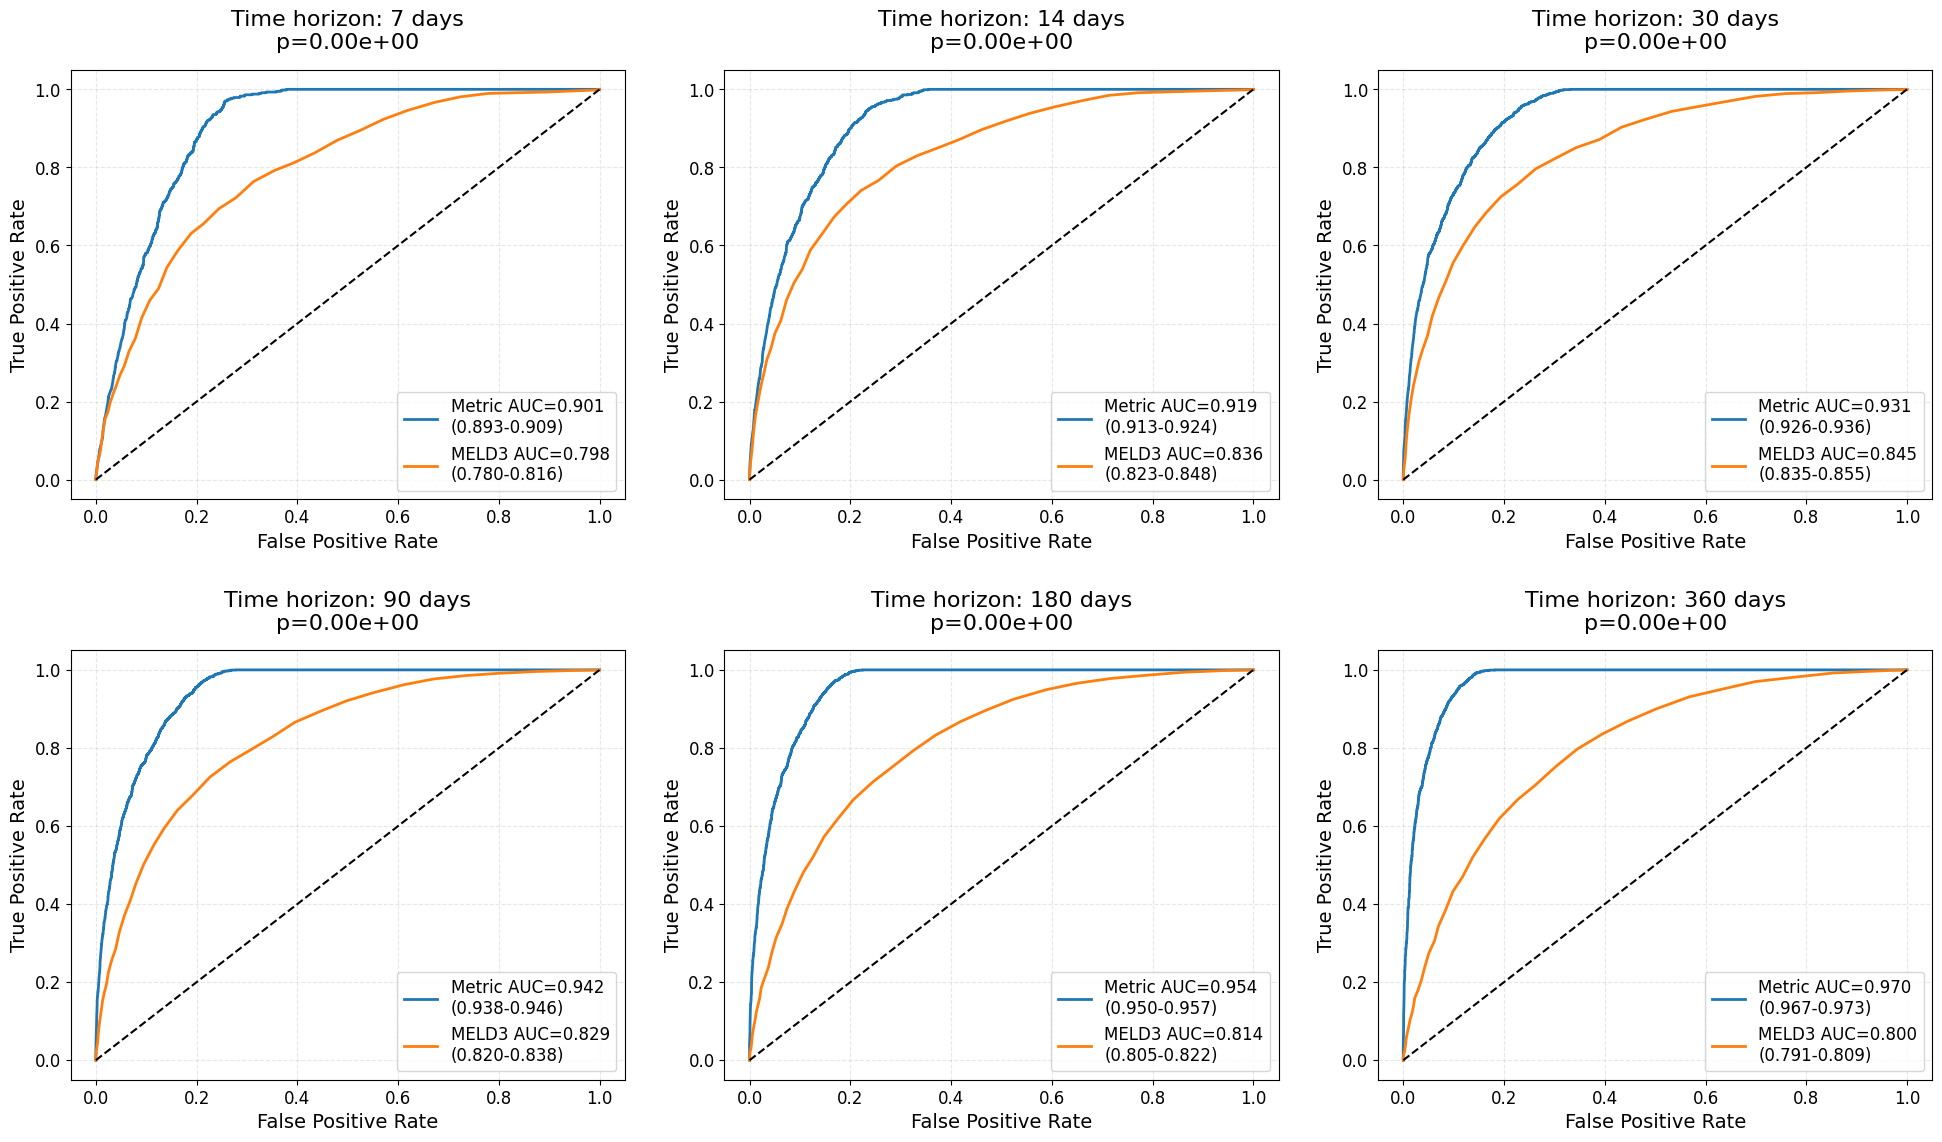

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set global font sizes at the start
plt.rcParams.update({
    'font.size': 14,          # Base font size
    'axes.titlesize': 16,     # Title font size
    'axes.labelsize': 14,     # Axis label size
    'xtick.labelsize': 12,    # X-axis tick labels
    'ytick.labelsize': 12,    # Y-axis tick labels
    'legend.fontsize': 12,    # Legend font size
})

def calculate_auc_comparison(y_true, score1, score2, n_bootstraps=1000):
    """
    Calculate AUCs and their difference with confidence interval using bootstrapping
    """
    # Convert inputs to numpy arrays if they aren't already
    y_true = np.array(y_true)
    score1 = np.array(score1)
    score2 = np.array(score2)

    rng = np.random.RandomState(42)
    auc_diffs = []
    auc1s = []
    auc2s = []

    # Calculate original AUCs
    orig_auc1 = roc_auc_score(y_true, score1)
    orig_auc2 = roc_auc_score(y_true, score2)

    # Bootstrap sampling
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score1_boot = score1[indices]
        score2_boot = score2[indices]
        y_boot = y_true[indices]

        auc1 = roc_auc_score(y_boot, score1_boot)
        auc2 = roc_auc_score(y_boot, score2_boot)
        auc1s.append(auc1)
        auc2s.append(auc2)
        auc_diffs.append(auc1 - auc2)

    # Calculate confidence intervals for individual AUCs
    auc1_ci = np.percentile(auc1s, [2.5, 97.5])
    auc2_ci = np.percentile(auc2s, [2.5, 97.5])
    diff_ci = np.percentile(auc_diffs, [2.5, 97.5])

    # Calculate p-value (two-sided)
    p_value = 2 * min(
        np.mean(np.array(auc_diffs) <= 0),
        np.mean(np.array(auc_diffs) >= 0)
    )

    return {
        'AUC1': orig_auc1,
        'AUC1_CI': auc1_ci,
        'AUC2': orig_auc2,
        'AUC2_CI': auc2_ci,
        'AUC_diff': orig_auc1 - orig_auc2,
        'CI_lower': diff_ci[0],
        'CI_upper': diff_ci[1],
        'p_value': p_value
    }

# Initialize results and plot
time_points = [7, 14, 30, 90, 180, 360]
results = []
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
axs = axs.ravel()

for idx, t in enumerate(tqdm(time_points)):
    # Get data for this time point
    df_all = real_df.copy()
    at_risk_mask = (
        (df_all['time_to_event'] >= t) |
        ((df_all['outcome'].isin([0, 2])) & (df_all['time_to_event'] <= t))
    )
    df_at_risk = df_all[at_risk_mask].copy()

    event_mask = (
        (df_at_risk['outcome'].isin([0, 2])) &
        (df_at_risk['time_to_event'] <= t)
    )
    event_indicator = np.array(event_mask.astype(int))

    # Convert to numpy arrays immediately
    risk_metric = np.array(-df_at_risk['median_time_to_event_metric'])
    risk_meld3 = np.array(df_at_risk['meld3'])

    # Calculate comparison metrics
    comparison = calculate_auc_comparison(
        event_indicator,
        risk_metric,
        risk_meld3
    )

    # Calculate ROC curves for plotting
    fpr_metric, tpr_metric, _ = roc_curve(event_indicator, risk_metric)
    fpr_meld3, tpr_meld3, _ = roc_curve(event_indicator, risk_meld3)

    # Plot with improved styling
    axs[idx].plot(fpr_metric, tpr_metric,
                 label=f'Metric AUC={comparison["AUC1"]:.3f}\n({comparison["AUC1_CI"][0]:.3f}-{comparison["AUC1_CI"][1]:.3f})',
                 linewidth=2)
    axs[idx].plot(fpr_meld3, tpr_meld3,
                 label=f'MELD3 AUC={comparison["AUC2"]:.3f}\n({comparison["AUC2_CI"][0]:.3f}-{comparison["AUC2_CI"][1]:.3f})',
                 linewidth=2)
    axs[idx].plot([0, 1], [0, 1], 'k--', linewidth=1.5)
    axs[idx].set_xlabel('False Positive Rate', fontsize=14)
    axs[idx].set_ylabel('True Positive Rate', fontsize=14)
    axs[idx].set_title(f'Time horizon: {t} days\np={comparison["p_value"]:.2e}',
                       fontsize=16, pad=15)
    axs[idx].legend(loc='lower right', fontsize=12, frameon=True)

    # Add grid for better readability
    axs[idx].grid(True, linestyle='--', alpha=0.3)

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_events_by_t': event_indicator.sum(),
        'Metric_AUC': comparison['AUC1'],
        'Metric_AUC_CI': f"({comparison['AUC1_CI'][0]:.3f}-{comparison['AUC1_CI'][1]:.3f})",
        'MELD3_AUC': comparison['AUC2'],
        'MELD3_AUC_CI': f"({comparison['AUC2_CI'][0]:.3f}-{comparison['AUC2_CI'][1]:.3f})",
        'AUC_Difference': comparison['AUC_diff'],
        'Diff_CI': f"({comparison['CI_lower']:.3f}-{comparison['CI_upper']:.3f})",
        'p_value': comparison['p_value']
    })

plt.tight_layout(pad=2.0)  # Increased padding between subplots

# Save figures before showing
plt.savefig('roc_curves.png',
            dpi=300,
            bbox_inches='tight',
            format='png',
            facecolor='white',
            edgecolor='none')

plt.savefig('roc_curves.tiff',
            dpi=300,
            bbox_inches='tight',
            format='tiff',
            facecolor='white',
            edgecolor='none',
            pil_kwargs={"compression": "lzw"})

# Print formatted results
print("\nTime-Dependent AUC with Confidence Intervals:")
print("=" * 100)
for row in results:
    print(f"\n{row['Time']} days:")
    print(f"Events: {row['N_events_by_t']}/{row['N_at_risk']} ({row['N_events_by_t']/row['N_at_risk']*100:.1f}%)")
    print(f"Metric AUC: {row['Metric_AUC']:.3f} {row['Metric_AUC_CI']}")
    print(f"MELD3 AUC: {row['MELD3_AUC']:.3f} {row['MELD3_AUC_CI']}")
    print(f"AUC Difference: {row['AUC_Difference']:.3f} {row['Diff_CI']}")
    if row['p_value'] < 0.05:
        significance = "significant"
    else:
        significance = "not significant"
    print(f"P-value: {row['p_value']:.4e} ({significance})")

plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

time_points = [7, 14, 30, 90, 180, 360]
results = []

df_all = real_df.copy()

for t in time_points:
    # Define at-risk set (patients who haven't died or been transplanted by time t)
    at_risk_mask = (
        (df_all['time_to_event'] >= t) |  # Still under observation
        ((df_all['outcome'] == 0) & (df_all['time_to_event'] <= t))  # Died by t
    )

    df_at_risk = df_all[at_risk_mask].copy()

    # Event indicator (death by time t)
    event_mask = (
        (df_at_risk['outcome'] == 0) &
        (df_at_risk['time_to_event'] <= t)
    )
    event_indicator = event_mask.astype(int)

    # Risk scores
    risk_metric = -df_at_risk['median_time_to_event_metric']
    risk_meld3 = df_at_risk['meld3']

    # AUC calculation
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_metric = roc_auc_score(event_indicator, risk_metric)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        auc_metric = None
        auc_meld3 = None

    # Count CUMULATIVE transplants up to time t in the FULL dataset
    n_transplants = sum(
        (df_all['outcome'] == 2) &
        (df_all['time_to_event'] <= t)
    )

    # Count those still in observation (not died, not transplanted by time t)
    n_still_waiting = sum(
        (df_all['time_to_event'] > t) &
        (df_all['outcome'] != 0)  # Not died
    )

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_events_by_t': event_indicator.sum(),
        'N_transplants_by_t': n_transplants,
        'N_still_waiting': n_still_waiting,
        'AUC_metric': auc_metric,
        'AUC_meld3': auc_meld3
    })

results_df = pd.DataFrame(results)
print("\nTime-Dependent AUC (Including Transplants as Censored):")
print(results_df)


Time-Dependent AUC (Including Transplants as Censored):
   Time  N_at_risk  N_events_by_t  N_transplants_by_t  N_still_waiting  \
0     7       8999            156                 416             6907   
1    14       8788            315                 592             6700   
2    30       8467            531                 844             6394   
3    90       7837            901                1247             5755   
4   180       7182           1170                1555             5114   
5   360       6329           1446                1817             4261   

   AUC_metric  AUC_meld3  
0    0.889749   0.900973  
1    0.892456   0.886428  
2    0.900633   0.877203  
3    0.910700   0.844853  
4    0.927640   0.823785  
5    0.951028   0.802510  


In [ ]:
# Focus on patients who died (outcome_encoded == 0)
death_mask = real_df['outcome'] == 0
df_deaths = real_df[death_mask].copy()

# Calculate IQR for each patient based on their synthetic neighbors
iqr_time_list_metric = []
for i in range(indices_metric.shape[0]):
    neighbor_times = syn_target[indices_metric[i]]
    q1 = np.percentile(neighbor_times, 25)
    q3 = np.percentile(neighbor_times, 75)
    iqr = q3 - q1
    iqr_time_list_metric.append(iqr)

# Add IQR to real_df
real_df['iqr_time_to_event_metric'] = iqr_time_list_metric

# Update df_deaths with the new IQR values
df_deaths = real_df[death_mask].copy()

# Calculate Q1 and Q3 using median and IQR
df_deaths['Q1'] = df_deaths['median_time_to_event_metric'] - (df_deaths['iqr_time_to_event_metric'] / 2)
df_deaths['Q3'] = df_deaths['median_time_to_event_metric'] + (df_deaths['iqr_time_to_event_metric'] / 2)

# Check if actual time falls within the range
df_deaths['within_iqr'] = (df_deaths['time_to_event'] >= df_deaths['Q1']) & \
                         (df_deaths['time_to_event'] <= df_deaths['Q3'])

# Filter for deaths within 90 days
early_death_mask = df_deaths['time_to_event'] <= 90
df_early_deaths = df_deaths[early_death_mask]

# Calculate overall proportion for 0-90 days
prop_within_iqr_90d = df_early_deaths['within_iqr'].mean()
total_early_deaths = len(df_early_deaths)

# Additional analysis for 0-90 day deaths
df_early_deaths['below_q1'] = df_early_deaths['time_to_event'] < df_early_deaths['Q1']
df_early_deaths['above_q3'] = df_early_deaths['time_to_event'] > df_early_deaths['Q3']

print(f"\nAnalysis for deaths within first 90 days (N = {total_early_deaths}):")
print(f"Proportion within predicted IQR: {prop_within_iqr_90d:.3f}")
print(f"Proportion below Q1: {df_early_deaths['below_q1'].mean():.3f}")
print(f"Proportion above Q3: {df_early_deaths['above_q3'].mean():.3f}")

# Calculate median IQR width and median prediction error
median_iqr_width = df_early_deaths['iqr_time_to_event_metric'].median()
median_error = (df_early_deaths['time_to_event'] - df_early_deaths['median_time_to_event_metric']).abs().median()

print(f"\nMedian IQR width: {median_iqr_width:.1f} days")
print(f"Median absolute prediction error: {median_error:.1f} days")


Analysis for deaths within first 90 days (N = 901):
Proportion within predicted IQR: 0.777
Proportion below Q1: 0.176
Proportion above Q3: 0.047

Median IQR width: 237.3 days
Median absolute prediction error: 60.6 days


<ipython-input-27-fdc13120e97a>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_early_deaths['below_q1'] = df_early_deaths['time_to_event'] < df_early_deaths['Q1']
<ipython-input-27-fdc13120e97a>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_early_deaths['above_q3'] = df_early_deaths['time_to_event'] > df_early_deaths['Q3']


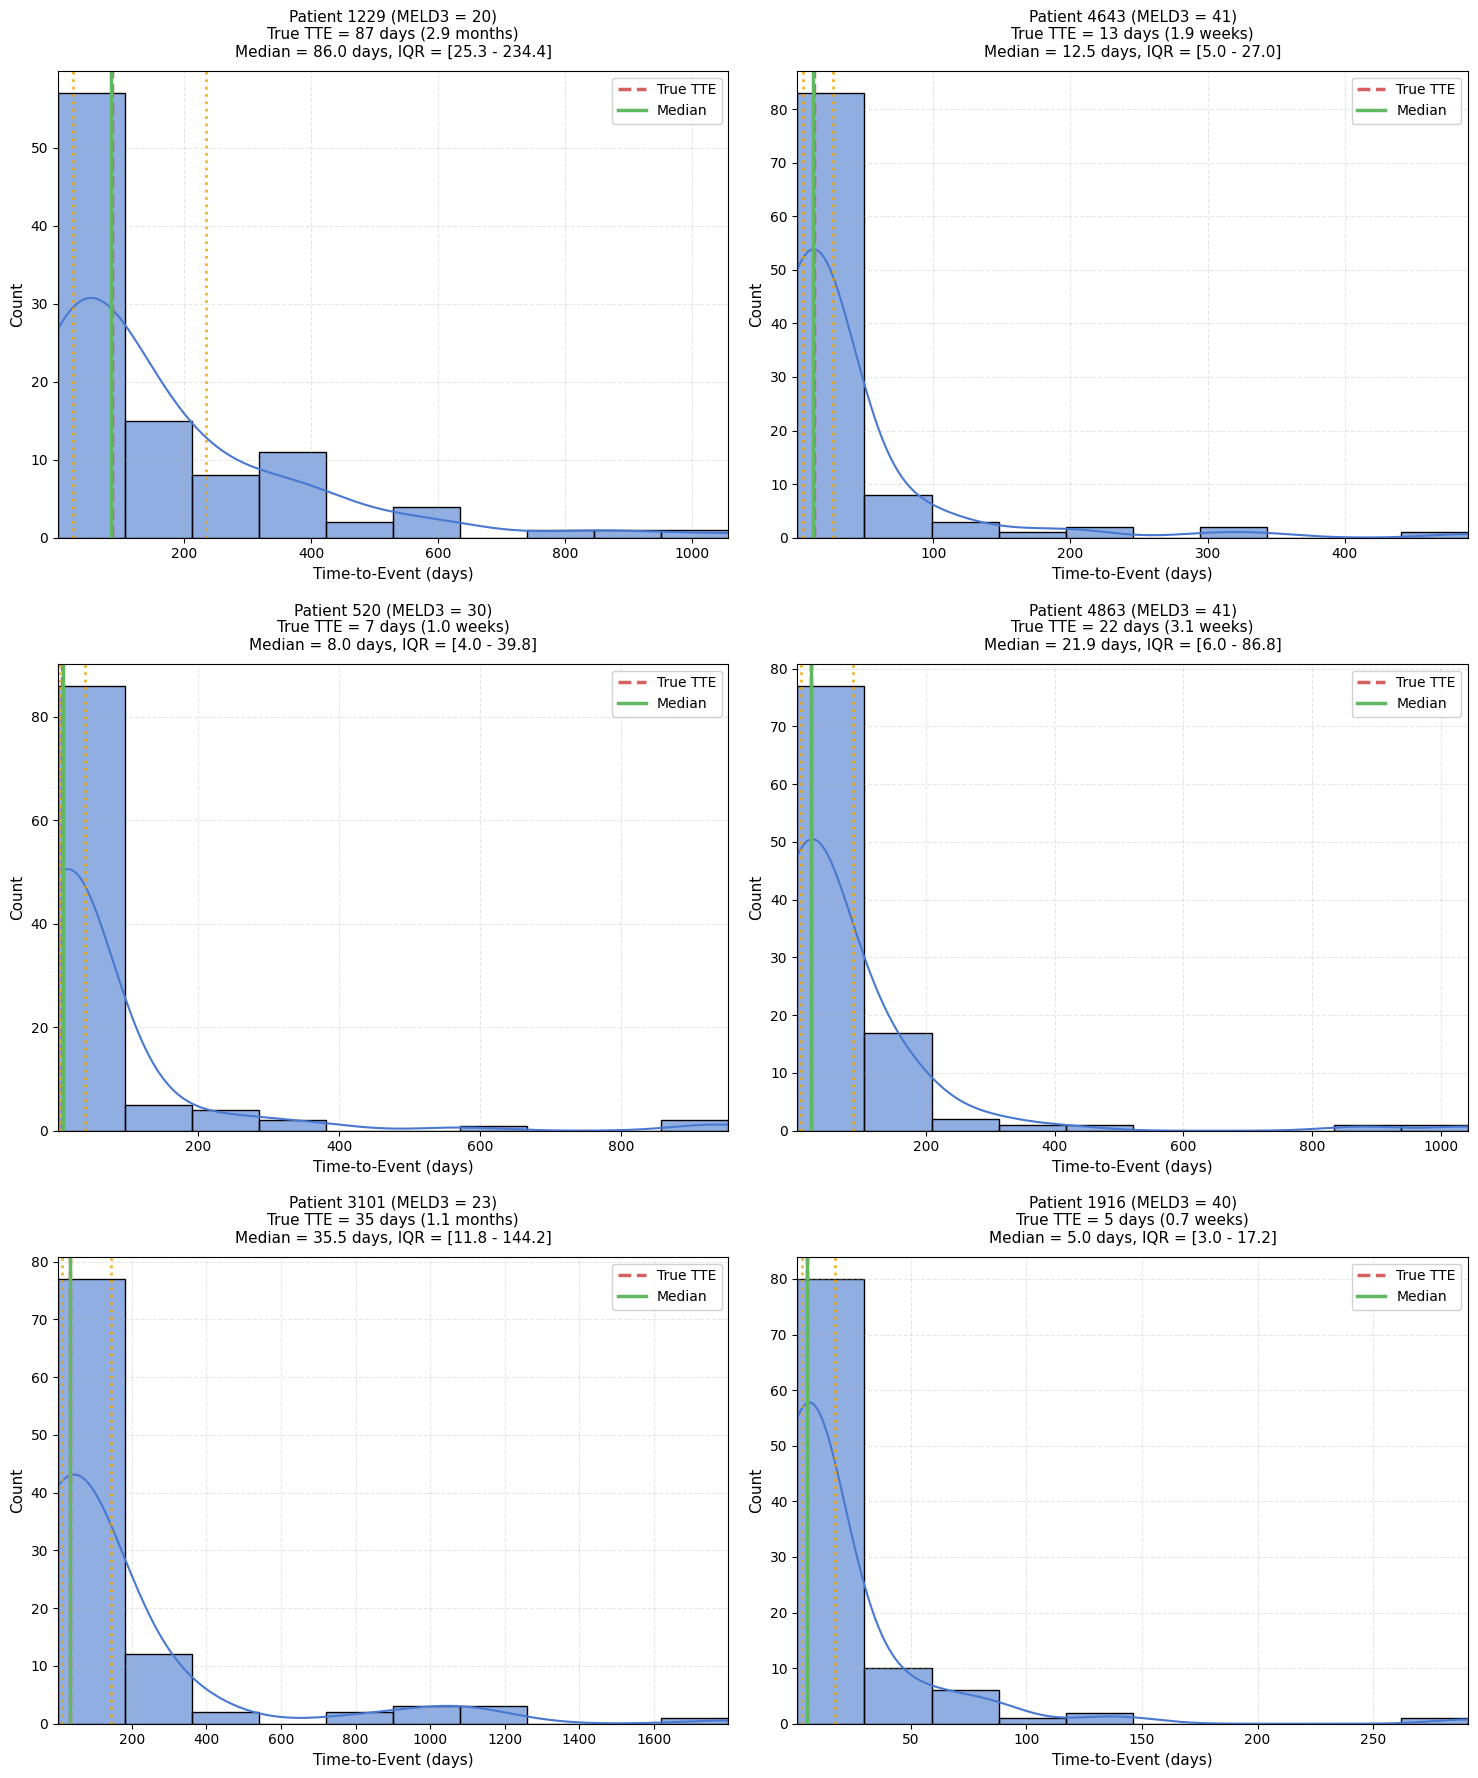

In [ ]:
# Calculate absolute difference between actual and predicted time
real_df['tte_diff'] = abs(real_df['time_to_event'] - real_df['median_time_to_event_metric'])

# Sort by smallest difference and get 6 random cases from top 100 closest matches
top_100_matches = real_df.nsmallest(100, 'tte_diff').index.values
selected_indices = np.random.choice(top_100_matches, size=6, replace=False)

# Create figure
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))
fig.patch.set_facecolor('white')
axes = axes.flatten()

for idx, ax in zip(selected_indices, axes):
    # Get synthetic neighbors
    neighbor_indices = indices_metric[idx][:100]
    neighbor_times = syn_target[neighbor_indices]

    # Calculate statistics
    q1 = np.percentile(neighbor_times, 25)
    q3 = np.percentile(neighbor_times, 75)
    median_syn = np.median(neighbor_times)
    range_str = f"[{q1:.1f} - {q3:.1f}]"

    # Get true time-to-event and MELD3
    true_time = real_df["time_to_event"].values[idx]
    meld3_score = real_df["INIT_MELD"].values[idx]  # Changed from meld3 to INIT_MELD

    # Determine the data range for neighbor_times
    t_min = np.min(neighbor_times)
    t_max = np.max(neighbor_times)

    # If all values are identical, artificially expand the range
    if t_min == t_max:
        t_min -= 0.5
        t_max += 0.5

    # Create exactly 10 bins between t_min and t_max
    bins_array = np.linspace(t_min, t_max, 11)

    # Plot histogram with KDE overlay
    sns.histplot(
        neighbor_times,
        bins=bins_array,
        kde=True,
        color='#4878D0',
        alpha=0.6,
        ax=ax,
        stat='count'
    )

    # Add vertical lines
    ax.axvline(true_time, color='#D65F5F', linestyle='--', linewidth=2.5,
               label='True TTE')
    ax.axvline(median_syn, color='#61B861', linestyle='-', linewidth=2.5,
               label='Median')
    ax.axvline(q1, color='#ECA400', linestyle=':', linewidth=2, alpha=0.8)
    ax.axvline(q3, color='#ECA400', linestyle=':', linewidth=2, alpha=0.8)

    # Customize appearance
    ax.set_xlabel("Time-to-Event (days)", fontsize=11)
    ax.set_ylabel("Count", fontsize=11)
    ax.tick_params(labelsize=10)

    # Format time string
    if true_time >= 30:
        time_str = f"{true_time:.0f} days ({true_time/30.44:.1f} months)"
    else:
        time_str = f"{true_time:.0f} days ({true_time/7:.1f} weeks)"

    ax.set_title(
        f"Patient {idx} (MELD3 = {meld3_score:.0f})\n"
        f"True TTE = {time_str}\n"
        f"Median = {median_syn:.1f} days, IQR = {range_str}",
        pad=10,
        fontsize=11
    )

    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xlim(t_min, t_max)
    ax.legend(fontsize=10, framealpha=0.9)

plt.tight_layout()

# Save figures
plt.savefig('survival_predictions_similar_tte_300dpi.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.savefig('survival_predictions_similar_tte_300dpi.tiff', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')

plt.show()

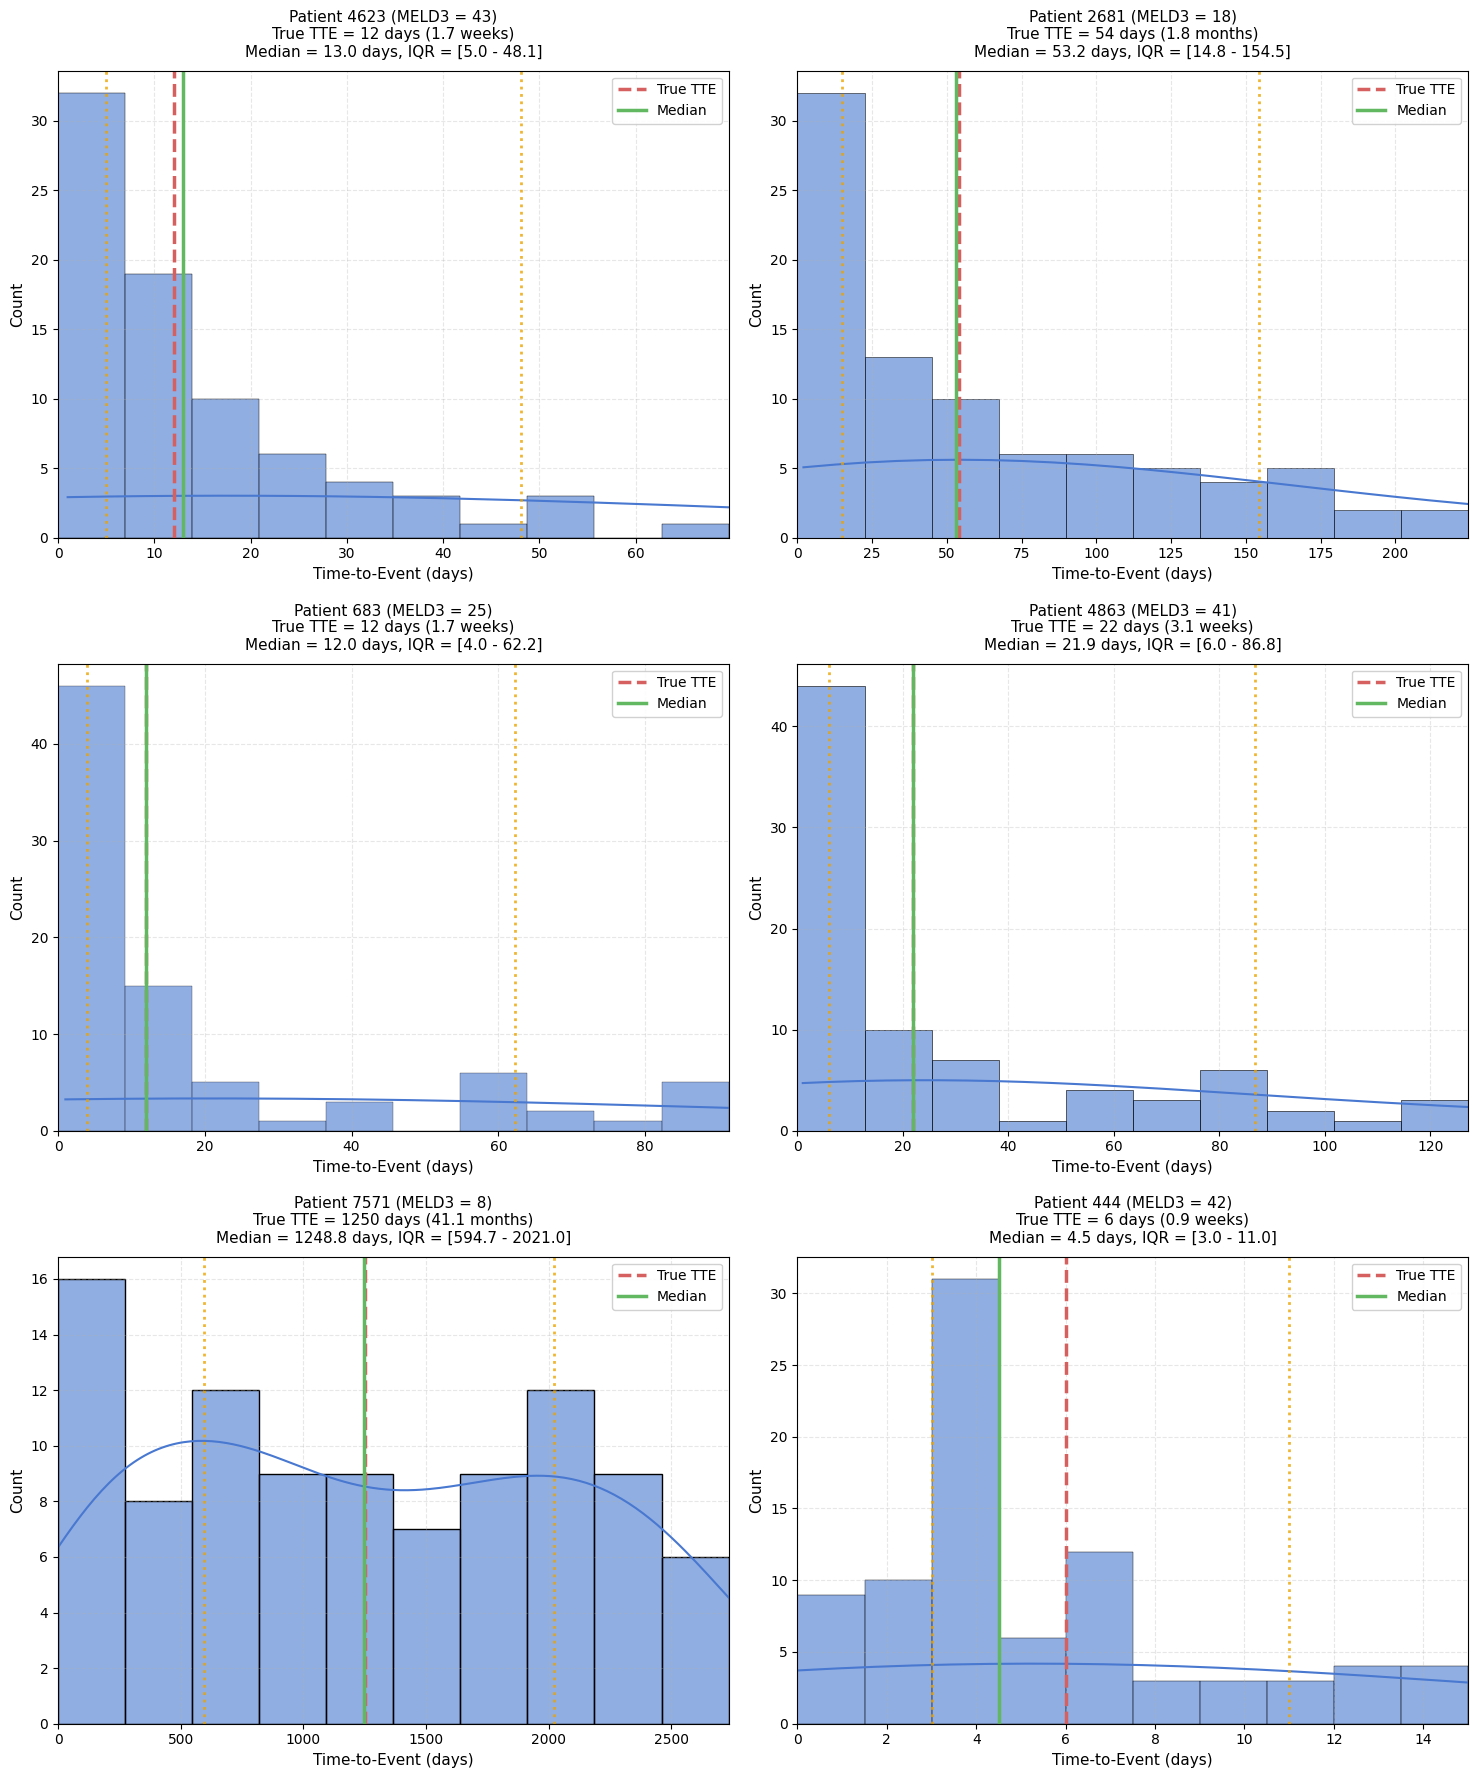

In [ ]:
# Calculate absolute difference between actual and predicted time
real_df['tte_diff'] = abs(real_df['time_to_event'] - real_df['median_time_to_event_metric'])

# Sort by smallest difference and get 6 random cases from top 100 closest matches
top_100_matches = real_df.nsmallest(100, 'tte_diff').index.values
selected_indices = np.random.choice(top_100_matches, size=6, replace=False)

# Create figure
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))
fig.patch.set_facecolor('white')
axes = axes.flatten()

for idx, ax in zip(selected_indices, axes):
    # Get synthetic neighbors
    neighbor_indices = indices_metric[idx][:100]
    neighbor_times = syn_target[neighbor_indices]

    # Calculate statistics
    q1 = np.percentile(neighbor_times, 25)
    q3 = np.percentile(neighbor_times, 75)
    iqr = q3 - q1

    # Set plot range to IQR plus padding
    x_min = max(0, q1 - iqr * 0.5)  # Add 50% of IQR as padding, but don't go below 0
    x_max = q3 + iqr * 0.5  # Add 50% of IQR as padding

    # Create 10 bins across this range
    bins_array = np.linspace(x_min, x_max, 11)

    median_syn = np.median(neighbor_times)
    range_str = f"[{q1:.1f} - {q3:.1f}]"

    # Get true time-to-event and MELD3
    true_time = real_df["time_to_event"].values[idx]
    meld3_score = real_df["INIT_MELD"].values[idx]

    # Plot histogram with KDE overlay using the custom bins
    sns.histplot(
        neighbor_times,
        bins=bins_array,
        kde=True,
        color='#4878D0',
        alpha=0.6,
        ax=ax,
        stat='count'
    )

    # Add vertical lines
    ax.axvline(true_time, color='#D65F5F', linestyle='--', linewidth=2.5,
               label='True TTE')
    ax.axvline(median_syn, color='#61B861', linestyle='-', linewidth=2.5,
               label='Median')
    ax.axvline(q1, color='#ECA400', linestyle=':', linewidth=2, alpha=0.8)
    ax.axvline(q3, color='#ECA400', linestyle=':', linewidth=2, alpha=0.8)

    # Customize appearance
    ax.set_xlabel("Time-to-Event (days)", fontsize=11)
    ax.set_ylabel("Count", fontsize=11)
    ax.tick_params(labelsize=10)

    # Format time string
    if true_time >= 30:
        time_str = f"{true_time:.0f} days ({true_time/30.44:.1f} months)"
    else:
        time_str = f"{true_time:.0f} days ({true_time/7:.1f} weeks)"

    ax.set_title(
        f"Patient {idx} (MELD3 = {meld3_score:.0f})\n"
        f"True TTE = {time_str}\n"
        f"Median = {median_syn:.1f} days, IQR = {range_str}",
        pad=10,
        fontsize=11
    )

    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xlim(x_min, x_max)
    ax.legend(fontsize=10, framealpha=0.9)

plt.tight_layout()

# Save figures
plt.savefig('survival_predictions_similar_tte_300dpi.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.savefig('survival_predictions_similar_tte_300dpi.tiff', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')

plt.show()